# Time Series Forecasting: Prophet, Theta, and Automated Methods

This notebook provides a comprehensive guide to time series forecasting using modern techniques. We'll explore:

- **Facebook Prophet**: A robust forecasting tool that handles seasonality, holidays, and trend changes
- **Theta Method**: A simple yet effective forecasting approach based on exponential smoothing
- **Automated Forecasting**: Using StatsForecast library for automated model selection and forecasting

Each method will be demonstrated with practical examples using real-world datasets, including milk production data and retail sales data.

## Technical Requirements

Before we begin, ensure you have the following libraries installed. This notebook uses:

- **Prophet**: Facebook's forecasting library for time series analysis
- **StatsForecast**: A collection of statistical and machine learning forecasting models
- **Pandas & NumPy**: For data manipulation
- **Matplotlib**: For visualization
- **Statsmodels**: For traditional time series methods like Theta

The following cell will install the required packages if they're not already available.

In [ ]:
!pip install -Uq prophet

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings


warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 5))

In [39]:
plt.rcParams["figure.figsize"] = [12, 5]

In [40]:
def split_data(data, test_split):
    """Split time series data into training and test sets.

    Args:
        data (pd.Series or pd.DataFrame): Time series data to split
        test_split (int): Number of periods to use for testing

    Returns:
        tuple: (train_data, test_data)
    """
    t_idx = test_split
    train, test = data[ : -t_idx], data[-t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test


## Part 1: Forecasting with Facebook Prophet

Prophet is an open-source forecasting tool developed by Facebook that excels at handling time series data with strong seasonal effects and multiple seasons of historical data. It's particularly good at:

- **Automatic seasonality detection**: Handles daily, weekly, and yearly patterns
- **Holiday effects**: Can incorporate custom holidays and events
- **Trend changes**: Automatically detects and adapts to trend shifts
- **Missing data**: Robust to missing values and irregular timestamps
- **Uncertainty quantification**: Provides prediction intervals

### 1.1 Data Preparation and Exploration

### 1.2 Loading and Preparing the Dataset

We'll use a monthly milk production dataset to demonstrate Prophet's capabilities. This dataset contains historical milk production data that exhibits clear seasonal patterns and trends.

Prophet requires data in a specific format:
- **ds**: Date column (datetime format)
- **y**: Target variable to forecast (numeric)

In [41]:
import prophet
prophet.__version__

'1.2.1'

In [42]:
from prophet import Prophet
import pandas as pd
from pathlib import Path

milk_file = Path('milk_production.csv')
milk = pd.read_csv(milk_file,
                   header=0,
                   parse_dates=['ds'],
                   names=['ds', 'y'])
milk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      168 non-null    datetime64[ns]
 1   y       168 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


<Axes: xlabel='ds'>

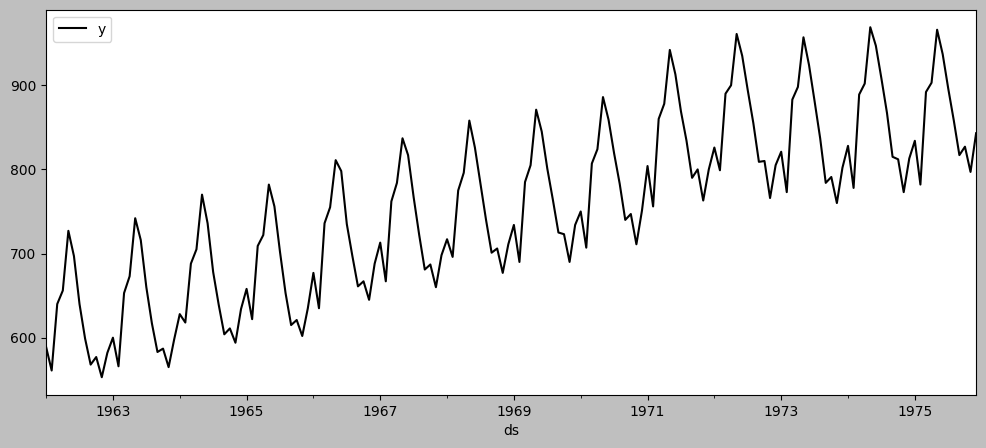

In [43]:
milk.plot(y='y', x='ds')

In [44]:
milk.head()

,ds,y
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


In [45]:
test_split = 12
train, test = split_data(milk, test_split)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

train: 156 , test: 12
Train: (156, 2)
Test: (12, 2)


In [46]:
display(milk.tail())
display(train.tail())
display(test.tail())

,ds,y
163,1975-08-01,858
164,1975-09-01,817
165,1975-10-01,827
166,1975-11-01,797
167,1975-12-01,843


,ds,y
151,1974-08-01,867
152,1974-09-01,815
153,1974-10-01,812
154,1974-11-01,773
155,1974-12-01,813


,ds,y
163,1975-08-01,858
164,1975-09-01,817
165,1975-10-01,827
166,1975-11-01,797
167,1975-12-01,843


<Axes: title={'center': 'Monthly Milk Production'}, xlabel='ds'>

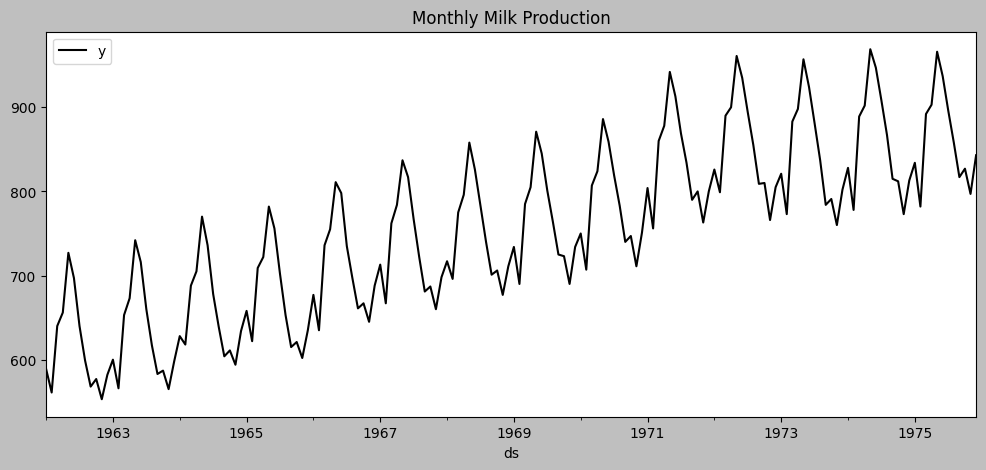

In [47]:
milk.set_index('ds').plot(title='Monthly Milk Production')

In [48]:
train.tail()

,ds,y
151,1974-08-01,867
152,1974-09-01,815
153,1974-10-01,812
154,1974-11-01,773
155,1974-12-01,813


In [49]:
# help(Prophet)

In [50]:
model = Prophet().fit(train)

15:23:50 - cmdstanpy - INFO - Chain [1] start processing
15:23:50 - cmdstanpy - INFO - Chain [1] done processing


### 1.3 Model Fitting and Forecasting

Now we'll fit a Prophet model to our training data and generate forecasts. Prophet automatically handles:
- Trend modeling (linear or logistic)
- Seasonal decomposition (daily, weekly, yearly)
- Holiday effects
- Changepoint detection for trend changes

In [51]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [52]:
model.uncertainty_samples

1000

In [53]:
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [54]:
future = model.make_future_dataframe(12, freq='MS')

In [55]:
future

,ds
0,1962-01-01
1,1962-02-01
2,1962-03-01
3,1962-04-01
4,1962-05-01
...,...
163,1975-08-01
164,1975-09-01
165,1975-10-01
166,1975-11-01


In [56]:
len(milk) == len(future)

True

In [57]:
future.shape

(168, 1)

In [58]:
print(future.tail(12))

            ds
156 1975-01-01
157 1975-02-01
158 1975-03-01
159 1975-04-01
160 1975-05-01
161 1975-06-01
162 1975-07-01
163 1975-08-01
164 1975-09-01
165 1975-10-01
166 1975-11-01
167 1975-12-01


In [59]:
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1962-01-01,607.669532,577.353657,595.702723,607.669532,607.669532,-20.923132,-20.923132,-20.923132,-20.923132,-20.923132,-20.923132,0.0,0.0,0.0,586.746400
1,1962-02-01,609.377074,537.523292,557.527225,609.377074,609.377074,-62.047277,-62.047277,-62.047277,-62.047277,-62.047277,-62.047277,0.0,0.0,0.0,547.329797
2,1962-03-01,610.919369,632.077693,650.208715,610.919369,610.919369,30.447679,30.447679,30.447679,30.447679,30.447679,30.447679,0.0,0.0,0.0,641.367049
3,1962-04-01,612.626911,649.360718,668.199715,612.626911,612.626911,46.369473,46.369473,46.369473,46.369473,46.369473,46.369473,0.0,0.0,0.0,658.996385
4,1962-05-01,614.279371,711.981807,731.468075,614.279371,614.279371,107.591522,107.591522,107.591522,107.591522,107.591522,107.591522,0.0,0.0,0.0,721.870893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1975-08-01,862.214274,841.846634,862.008216,860.170809,864.297982,-11.812804,-11.812804,-11.812804,-11.812804,-11.812804,-11.812804,0.0,0.0,0.0,850.401470
164,1975-09-01,862.515912,797.895171,818.847330,860.079443,865.057361,-54.509809,-54.509809,-54.509809,-54.509809,-54.509809,-54.509809,0.0,0.0,0.0,808.006103
165,1975-10-01,862.807819,801.283025,822.637038,859.863811,866.004220,-51.354978,-51.354978,-51.354978,-51.354978,-51.354978,-51.354978,0.0,0.0,0.0,811.452841
166,1975-11-01,863.109457,769.204502,790.155634,859.536729,866.893217,-83.595913,-83.595913,-83.595913,-83.595913,-83.595913,-83.595913,0.0,0.0,0.0,779.513543


In [60]:
forecast.columns.tolist()

['ds',
 'trend',
 'yhat_lower',
 'yhat_upper',
 'trend_lower',
 'trend_upper',
 'additive_terms',
 'additive_terms_lower',
 'additive_terms_upper',
 'yearly',
 'yearly_lower',
 'yearly_upper',
 'multiplicative_terms',
 'multiplicative_terms_lower',
 'multiplicative_terms_upper',
 'yhat']

In [61]:
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
163,1975-08-01,862.214274,841.846634,862.008216,860.170809,864.297982,-11.812804,-11.812804,-11.812804,-11.812804,-11.812804,-11.812804,0.0,0.0,0.0,850.401470
164,1975-09-01,862.515912,797.895171,818.847330,860.079443,865.057361,-54.509809,-54.509809,-54.509809,-54.509809,-54.509809,-54.509809,0.0,0.0,0.0,808.006103
165,1975-10-01,862.807819,801.283025,822.637038,859.863811,866.004220,-51.354978,-51.354978,-51.354978,-51.354978,-51.354978,-51.354978,0.0,0.0,0.0,811.452841
166,1975-11-01,863.109457,769.204502,790.155634,859.536729,866.893217,-83.595913,-83.595913,-83.595913,-83.595913,-83.595913,-83.595913,0.0,0.0,0.0,779.513543
167,1975-12-01,863.401364,803.654491,824.543309,859.110937,867.958966,-49.320429,-49.320429,-49.320429,-49.320429,-49.320429,-49.320429,0.0,0.0,0.0,814.080935


In [62]:
cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']

In [63]:
forecast[cols].head()

,ds,yhat,yhat_lower,yhat_upper
0,1962-01-01,586.746400,577.353657,595.702723
1,1962-02-01,547.329797,537.523292,557.527225
2,1962-03-01,641.367049,632.077693,650.208715
3,1962-04-01,658.996385,649.360718,668.199715
4,1962-05-01,721.870893,711.981807,731.468075


In [64]:
pd.concat([forecast['yhat'].iloc[-5:], test['y'].iloc[-5:]], axis=1)

,yhat,y
163,850.401470,858
164,808.006103,817
165,811.452841,827
166,779.513543,797
167,814.080935,843


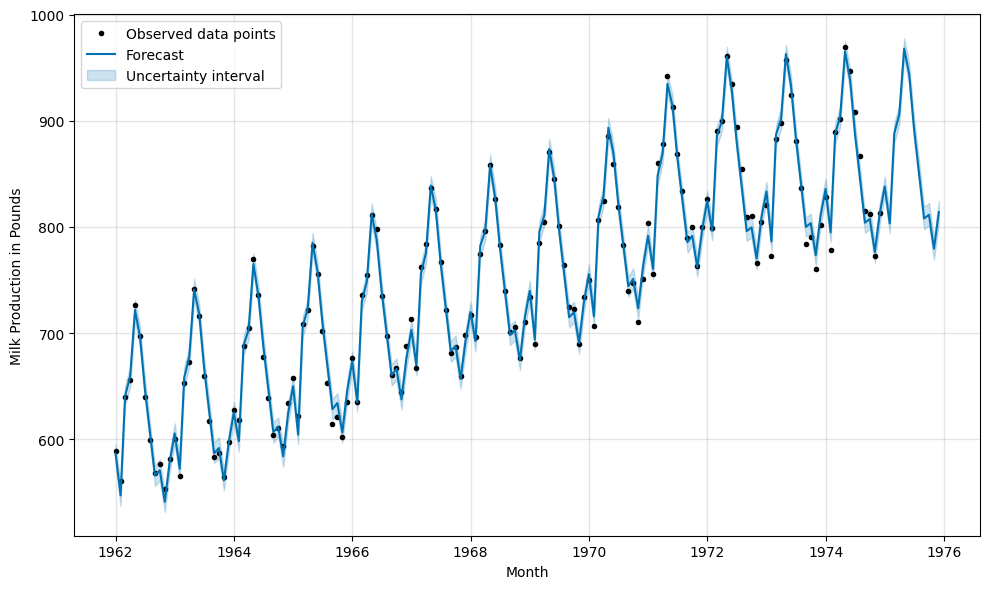

In [65]:
model.plot(forecast,
           ylabel='Milk Production in Pounds',
           xlabel='Month',
           include_legend=True);

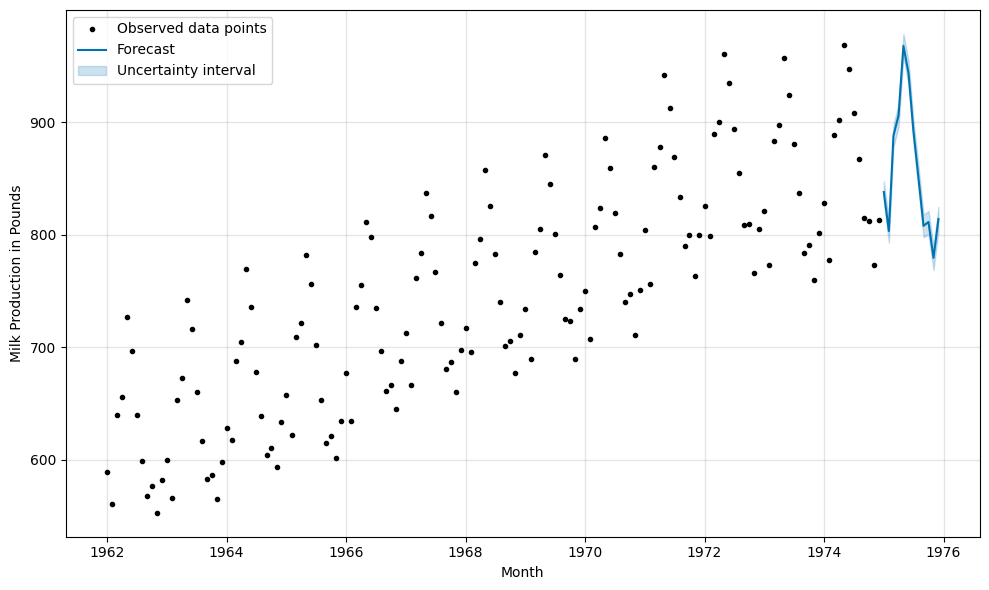

In [66]:
model.plot(model.predict(test),
           ylabel='Milk Production in Pounds',
           xlabel='Month',
          include_legend=True);

In [67]:
model_95 = Prophet(seasonality_mode='additive',
                interval_width=0.95).fit(train)
forecast_95 = model_95.predict(future)
forecast_95[cols].head()

15:23:57 - cmdstanpy - INFO - Chain [1] start processing


15:23:58 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,1962-01-01,586.746400,572.537269,602.398617
1,1962-02-01,547.329797,532.973204,561.347980
2,1962-03-01,641.367049,625.190940,657.175823
3,1962-04-01,658.996385,644.586198,673.255716
4,1962-05-01,721.870893,706.688178,736.730149


In [68]:
forecast[cols].head()

,ds,yhat,yhat_lower,yhat_upper
0,1962-01-01,586.746400,577.353657,595.702723
1,1962-02-01,547.329797,537.523292,557.527225
2,1962-03-01,641.367049,632.077693,650.208715
3,1962-04-01,658.996385,649.360718,668.199715
4,1962-05-01,721.870893,711.981807,731.468075


In [69]:
forecast_95[cols].tail()

,ds,yhat,yhat_lower,yhat_upper
163,1975-08-01,850.401470,835.118450,867.034136
164,1975-09-01,808.006103,792.004008,824.603637
165,1975-10-01,811.452841,795.814932,827.259036
166,1975-11-01,779.513543,763.394770,797.779591
167,1975-12-01,814.080935,796.751931,830.754739


In [70]:
forecast[cols].tail()

,ds,yhat,yhat_lower,yhat_upper
163,1975-08-01,850.401470,841.846634,862.008216
164,1975-09-01,808.006103,797.895171,818.847330
165,1975-10-01,811.452841,801.283025,822.637038
166,1975-11-01,779.513543,769.204502,790.155634
167,1975-12-01,814.080935,803.654491,824.543309


In [71]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
163,1975-08-01,862.214274,841.846634,862.008216,860.170809,864.297982,-11.812804,-11.812804,-11.812804,-11.812804,-11.812804,-11.812804,0.0,0.0,0.0,850.401470
164,1975-09-01,862.515912,797.895171,818.847330,860.079443,865.057361,-54.509809,-54.509809,-54.509809,-54.509809,-54.509809,-54.509809,0.0,0.0,0.0,808.006103
165,1975-10-01,862.807819,801.283025,822.637038,859.863811,866.004220,-51.354978,-51.354978,-51.354978,-51.354978,-51.354978,-51.354978,0.0,0.0,0.0,811.452841
166,1975-11-01,863.109457,769.204502,790.155634,859.536729,866.893217,-83.595913,-83.595913,-83.595913,-83.595913,-83.595913,-83.595913,0.0,0.0,0.0,779.513543
167,1975-12-01,863.401364,803.654491,824.543309,859.110937,867.958966,-49.320429,-49.320429,-49.320429,-49.320429,-49.320429,-49.320429,0.0,0.0,0.0,814.080935


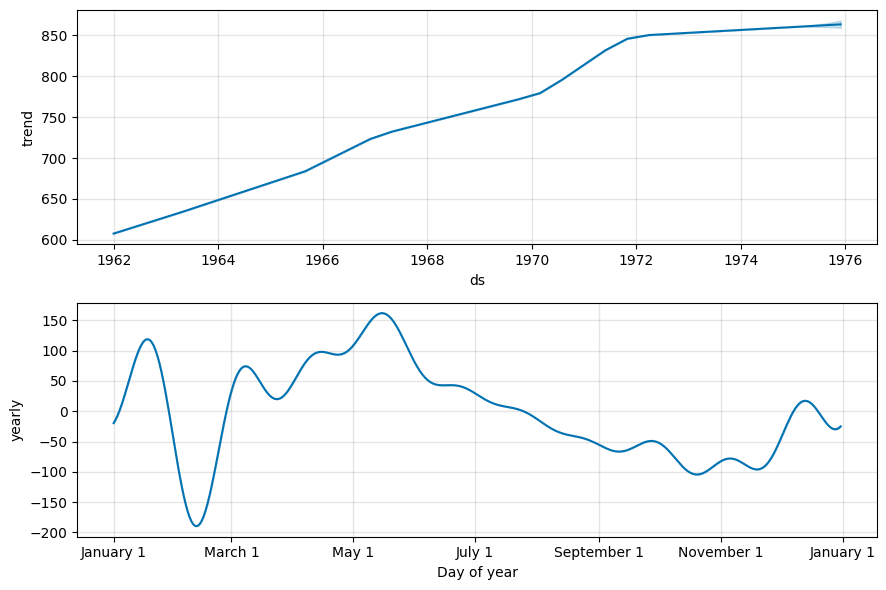

In [72]:
model.plot_components(forecast);

### 1.4 Model Visualization and Component Analysis

Prophet provides powerful visualization tools to understand:
- **Forecast plots**: Shows historical data, forecast, and uncertainty intervals
- **Component plots**: Breaks down the forecast into trend, seasonal, and holiday components
- **Changepoint analysis**: Identifies points where the trend changes significantly

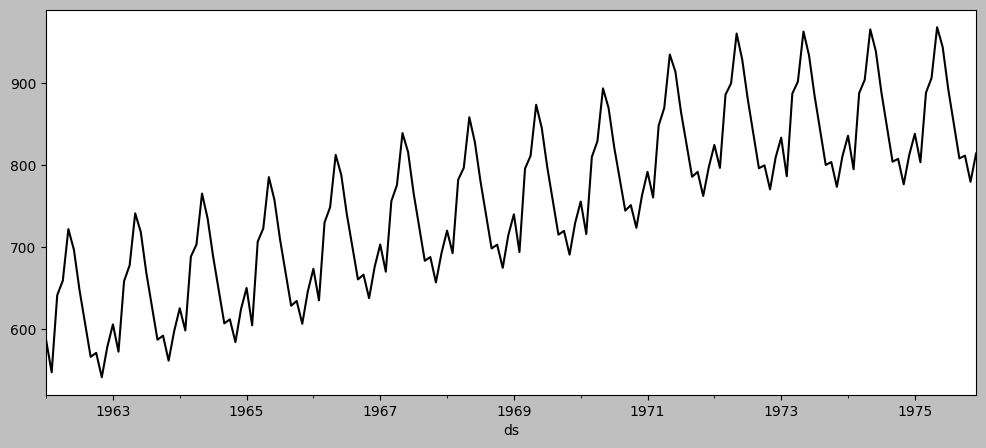

In [73]:
forecast_tmp = forecast.set_index('ds')
(forecast_tmp['trend']+forecast_tmp['yearly']).plot();

In [74]:
sum((forecast['trend']*forecast['yearly']) == forecast['yhat'])

0

In [75]:
(forecast['trend']+forecast['yearly']).head()

0    586.746400
1    547.329797
2    641.367049
3    658.996385
4    721.870893
dtype: float64

In [76]:
forecast['yhat'].head()

0    586.746400
1    547.329797
2    641.367049
3    658.996385
4    721.870893
Name: yhat, dtype: float64

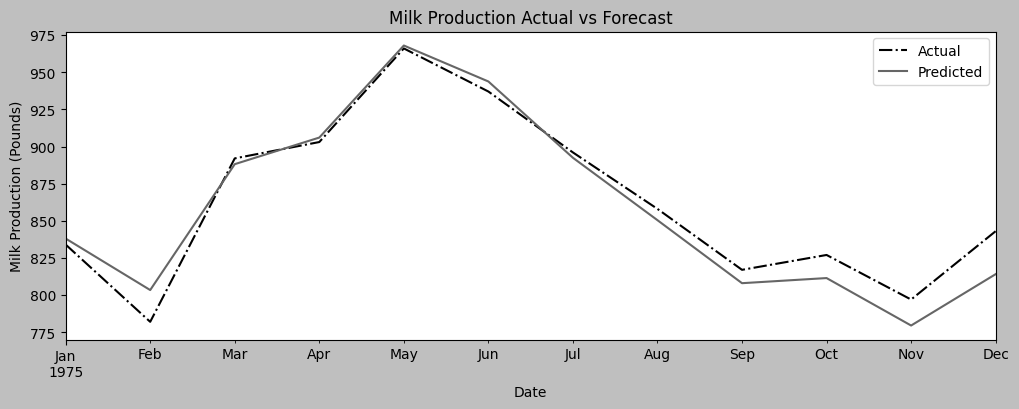

In [77]:
n = len(test)
ax = test.plot(x='ds', y='y',
               label='Actual',
               style='-.',
               figsize=(12,4), xlabel='Date')

forecast.tail(n).plot(x='ds', y='yhat',
              label='Predicted',
              ax=ax,
              title='Milk Production Actual vs Forecast',
              xlabel='Date',
              ylabel='Milk Production (Pounds)');

## Part 2: Understanding Prophet's Inner Workings

Prophet decomposes time series into several components:

**y(t) = trend(t) + seasonal(t) + holidays(t) + error(t)**

Where:
- **trend(t)**: Long-term growth or decline
- **seasonal(t)**: Periodic patterns (daily, weekly, yearly)
- **holidays(t)**: Effects of holidays and special events
- **error(t)**: Unexplained variation

### 2.1 Customizing Seasonality

In [78]:
from prophet.plot import plot_yearly

model_y4 = Prophet(seasonality_mode='additive',
                  interval_width=0.80,
                  yearly_seasonality=4).fit(train)
forecast_y4 = model_y4.predict(future)


15:24:14 - cmdstanpy - INFO - Chain [1] start processing
15:24:14 - cmdstanpy - INFO - Chain [1] done processing


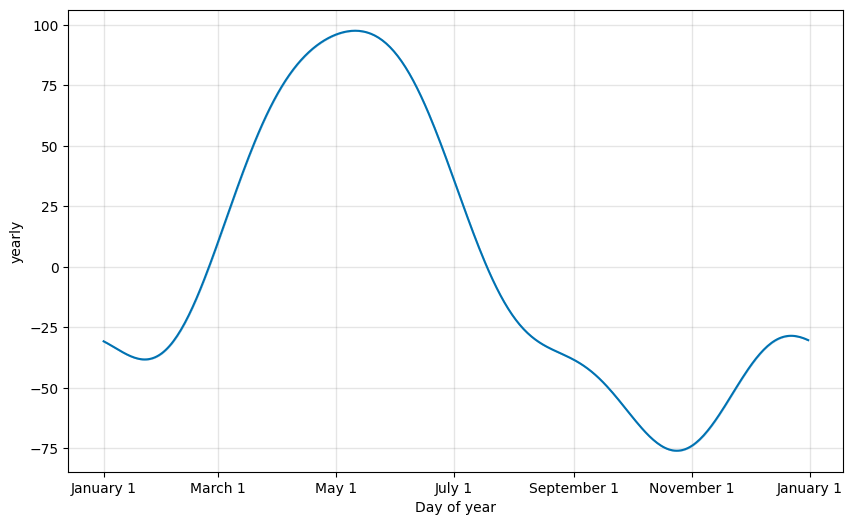

In [79]:
# updated model
plot_yearly(model_y4);

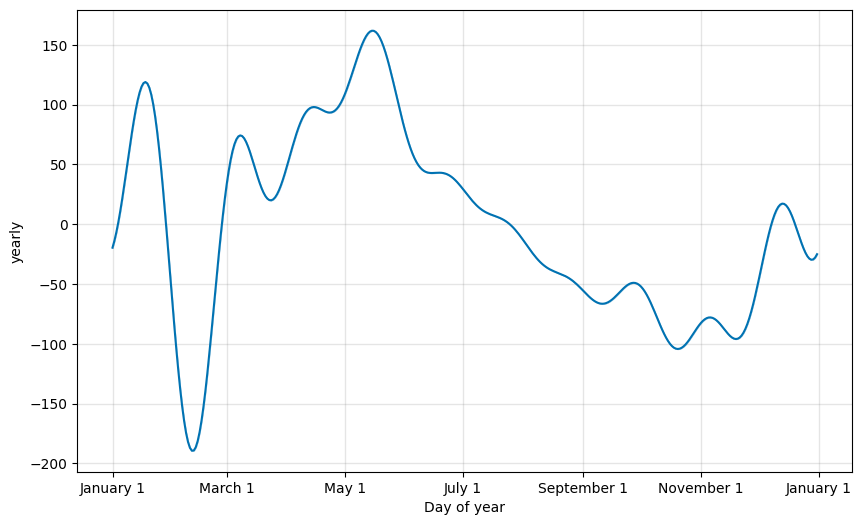

In [80]:
# original model
plot_yearly(model);

In [81]:
model.changepoints.shape

(25,)

### 2.2 Changepoint Detection

Changepoints are moments in time where the trend of the time series changes significantly. Prophet automatically detects these points and allows the trend to change slope at those locations.

The algorithm:
1. Places potential changepoints at regular intervals
2. Uses a sparse prior to encourage the trend to be piece-wise constant
3. Estimates the probability of a changepoint at each location

In [82]:
model.changepoints.head()

5    1962-06-01
10   1962-11-01
15   1963-04-01
20   1963-09-01
25   1964-02-01
Name: ds, dtype: datetime64[ns]

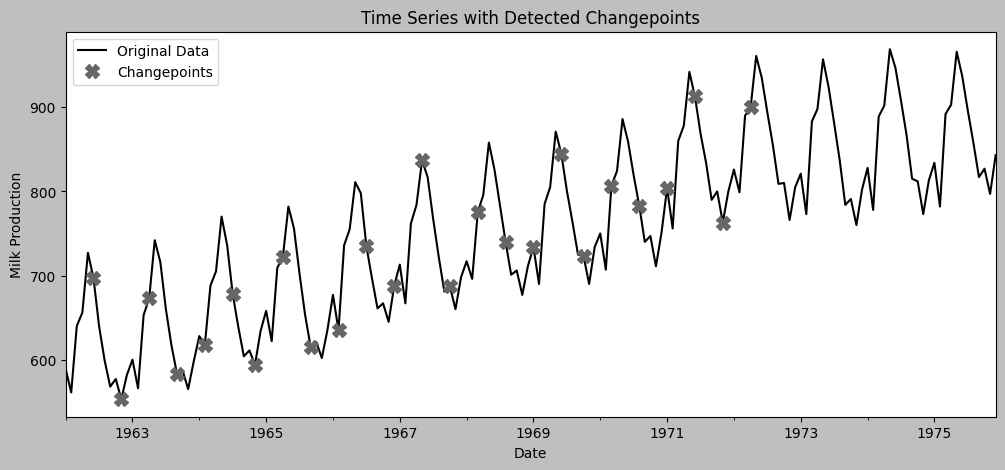

In [83]:
ax = milk.set_index('ds').plot(figsize=(12,5))
milk.set_index('ds').loc[model.changepoints].plot(
    style='X',
    ax=ax,
    markersize=10
)
plt.xlabel('Date')
plt.ylabel('Milk Production')
plt.title('Time Series with Detected Changepoints')
plt.legend(['Original Data', 'Changepoints']);

In [84]:
model_no_uncertainty = Prophet(uncertainty_samples=False).fit(train)
forecast_no_uncertainty  = model_no_uncertainty.predict(future)
forecast_no_uncertainty.columns.tolist()

15:24:20 - cmdstanpy - INFO - Chain [1] start processing
15:24:20 - cmdstanpy - INFO - Chain [1] done processing


['ds', 'trend', 'additive_terms', 'yearly', 'multiplicative_terms', 'yhat']

### 2.3 Uncertainty Quantification

Prophet can quantify uncertainty in forecasts through:
- **Prediction intervals**: Range of likely values for future observations
- **Monte Carlo simulation**: Generates multiple possible futures
- **Uncertainty samples**: Number of simulations to run (default: 1000)

Higher uncertainty samples provide more accurate intervals but take longer to compute.

## Part 3: Advanced Prophet Features

This section explores advanced capabilities that make Prophet suitable for production forecasting systems.

### 3.1 Visualizing Changepoints

### Changepoint Detection

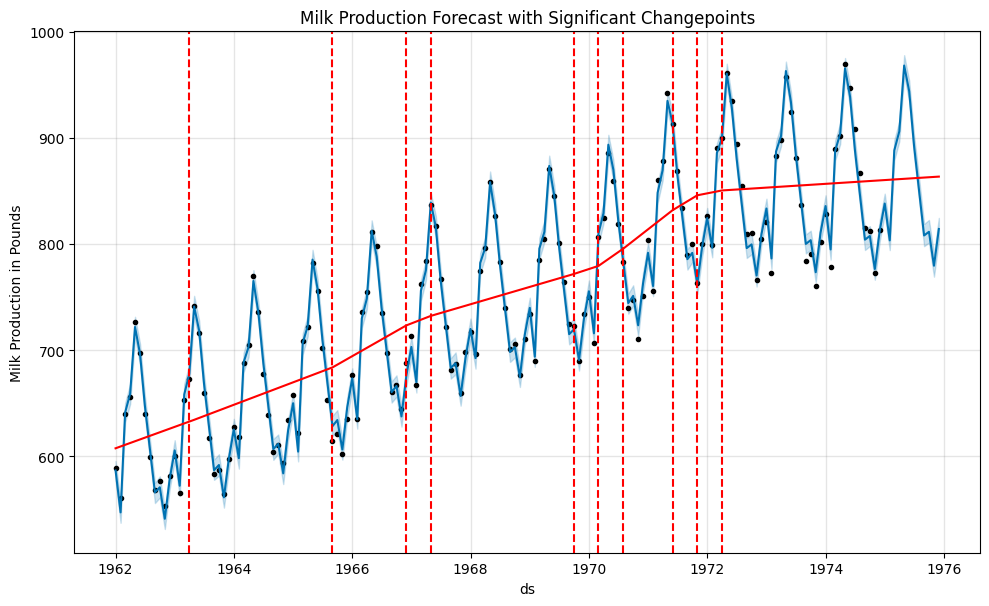

In [85]:
from prophet.plot import add_changepoints_to_plot

# Create base plot with forecast
fig = model.plot(forecast, ylabel='Milk Production in Pounds')
# Add changepoint visualization
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.title('Milk Production Forecast with Significant Changepoints');

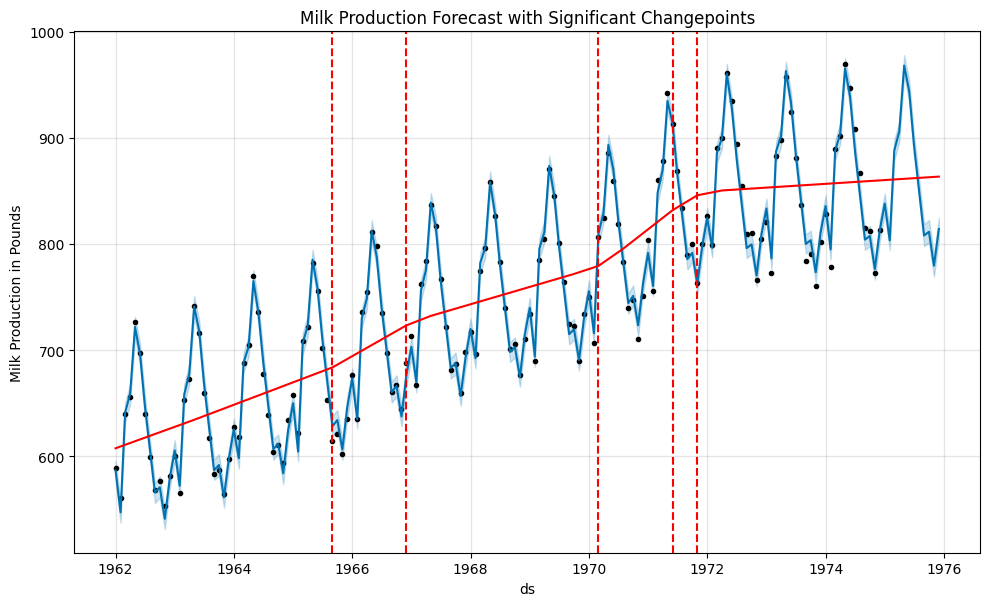

In [86]:
from prophet.plot import add_changepoints_to_plot

# Create base plot with forecast
fig = model.plot(forecast, ylabel='Milk Production in Pounds')
# Add changepoint visualization
add_changepoints_to_plot(fig.gca(), model, forecast, threshold=0.1)
plt.title('Milk Production Forecast with Significant Changepoints');

In [87]:
model.params.keys()

odict_keys(['lp__', 'k', 'm', 'delta', 'sigma_obs', 'beta', 'trend'])

In [88]:
print(model.params['delta'])

[[-1.8635677e-08  6.7579084e-05  1.2344302e-02  8.4046894e-04
   2.3258132e-09  1.5125744e-08 -4.2878637e-08  1.2386173e-08
   1.4075384e-01  3.7770794e-08 -1.4071105e-09 -1.3367466e-01
  -7.1572626e-02 -8.0784341e-09  1.0436518e-08  1.2975440e-08
   7.2688159e-04  3.0892503e-03  2.2464995e-02  2.7399302e-01
   6.1520018e-02 -9.4088656e-09 -1.3080451e-01 -3.0201454e-01
  -9.8502031e-02]]


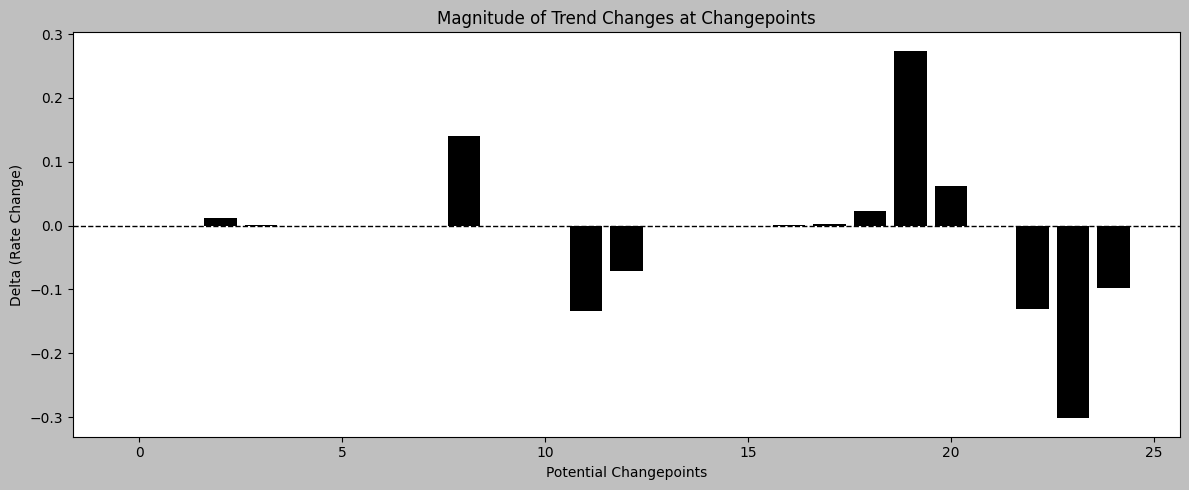

In [89]:
# Extract delta values
deltas = model.params['delta'].ravel()
indices = list(range(len(deltas)))

# Plot bar chart
plt.bar(indices, deltas)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title('Magnitude of Trend Changes at Changepoints')
plt.xlabel('Potential Changepoints')
plt.ylabel('Delta (Rate Change)')
plt.tight_layout();


### 3.2 Cross-Validation and Performance Evaluation

Cross-validation for time series is different from traditional CV because it must respect temporal order. Prophet provides built-in cross-validation that:

1. **Time series split**: Uses rolling forecast origin
2. **Multiple horizons**: Tests different forecast lengths
3. **Performance metrics**: Calculates MAE, MSE, RMSE, MAPE, etc.

The process:
- Train on initial data period
- Forecast next period
- Compare with actual values
- Expand training window and repeat

In [90]:
len(milk)

168

In [91]:
milk.head(1)

,ds,y
0,1962-01-01,589


In [92]:
milk.tail(1)

,ds,y
167,1975-12-01,843


Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.
The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of yhat vs. y.

In [93]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation over the last 12 months
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon='365 days')

# View the cross-validation results
df_cv.head()


  0%|          | 0/19 [00:00<?, ?it/s]15:24:30 - cmdstanpy - INFO - Chain [1] start processing
15:24:40 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/19 [00:09<02:58,  9.89s/it]15:24:40 - cmdstanpy - INFO - Chain [1] start processing
15:24:40 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 2/19 [00:10<01:11,  4.18s/it]15:24:40 - cmdstanpy - INFO - Chain [1] start processing
15:24:40 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 3/19 [00:10<00:38,  2.38s/it]15:24:40 - cmdstanpy - INFO - Chain [1] start processing
15:24:40 - cmdstanpy - INFO - Chain [1] done processing
 21%|██        | 4/19 [00:10<00:23,  1.55s/it]15:24:40 - cmdstanpy - INFO - Chain [1] start processing
15:24:40 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▋       | 5/19 [00:10<00:15,  1.07s/it]15:24:41 - cmdstanpy - INFO - Chain [1] start processing
15:24:41 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▏      | 6/19 [00:11<00:10,  1.27it/s]15:24:41

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1965-02-01,622.995283,620.719316,625.498896,622,1965-01-17
1,1965-03-01,706.794974,699.703628,714.869396,709,1965-01-17
2,1965-04-01,721.831122,707.509677,737.117226,722,1965-01-17
3,1965-05-01,785.856032,763.135916,810.833130,782,1965-01-17
4,1965-06-01,753.513794,721.181799,789.558911,756,1965-01-17


In [94]:
print(df_cv.head())

          ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 1965-02-01  622.995283  620.719316  625.498896  622 1965-01-17
1 1965-03-01  706.794974  699.703628  714.869396  709 1965-01-17
2 1965-04-01  721.831122  707.509677  737.117226  722 1965-01-17
3 1965-05-01  785.856032  763.135916  810.833130  782 1965-01-17
4 1965-06-01  753.513794  721.181799  789.558911  756 1965-01-17


In [95]:
df_perf = performance_metrics(df_cv)
print(df_perf.iloc[: , :-1].head())

  horizon         mse       rmse        mae      mape     mdape     smape
0 37 days  243.488992  15.604134  12.054727  0.015619  0.013978  0.015579
1 41 days  245.076026  15.654904  12.112809  0.015783  0.013978  0.015727
2 42 days  252.005666  15.874686  12.339839  0.016023  0.013978  0.015986
3 43 days  244.103095  15.623799  11.832405  0.015406  0.011797  0.015363
4 46 days  247.638643  15.736538  12.019037  0.015649  0.013978  0.015614


In [96]:
df_cv.shape

(228, 6)

In [97]:
performance_metrics(df_cv).shape

(176, 8)

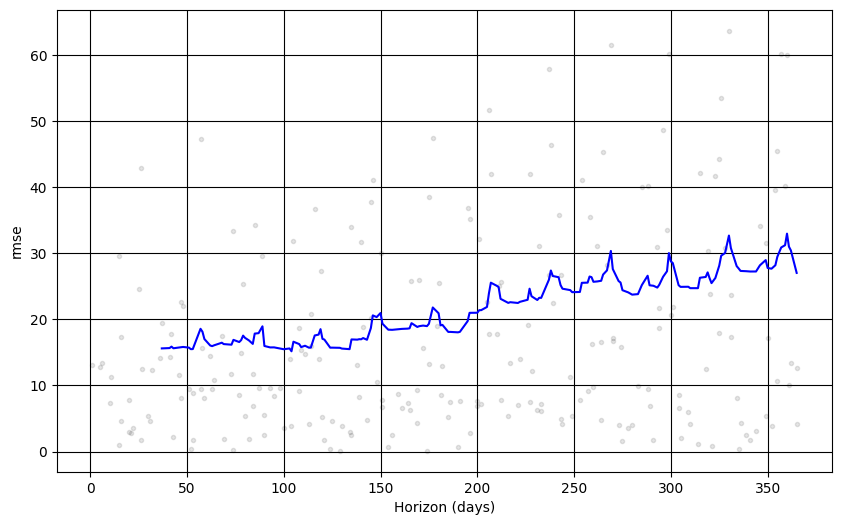

In [98]:
from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv,
                             metric='rmse',
                             rolling_window=0.1,
                             point_color='black');

### 3.3 Incorporating Holidays and External Regressors

Real-world forecasting often involves external factors that influence the time series. Prophet can incorporate:

**Holidays**: Special dates that affect the time series (Christmas, New Year, etc.)
**Regressors**: External variables that correlate with the target (temperature, promotions, economic indicators)

Benefits:
- **Improved accuracy**: Captures known external influences
- **Better planning**: Accounts for predictable events
- **Scenario analysis**: Test "what-if" scenarios with different external conditions

In [99]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [100]:
retail = Path('weekly_sales.csv')
retail_df = pd.read_csv(retail, parse_dates=['Date'])
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   Weekly_Sales  143 non-null    float64       
 2   Holiday_Flag  143 non-null    float64       
 3   Temperature   143 non-null    float64       
 4   Fuel_Price    143 non-null    float64       
 5   CPI           143 non-null    float64       
 6   Unemployment  143 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 7.9 KB


In [101]:
retail_df.rename(columns={'Date': 'ds',
                          'Weekly_Sales':'y'},
                 inplace=True)
retail_df.head()

,ds,y,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,1105572.01,0.0,34.04,2.7178,167.730885,8.619
1,2010-02-12,1074148.39,1.0,34.15,2.6940,167.825608,8.619
2,2010-02-19,1072822.08,0.0,37.72,2.6721,167.871686,8.619
3,2010-02-26,977079.36,0.0,39.24,2.6839,167.909657,8.619
4,2010-03-05,1041588.23,0.0,42.92,2.7312,167.947628,8.619


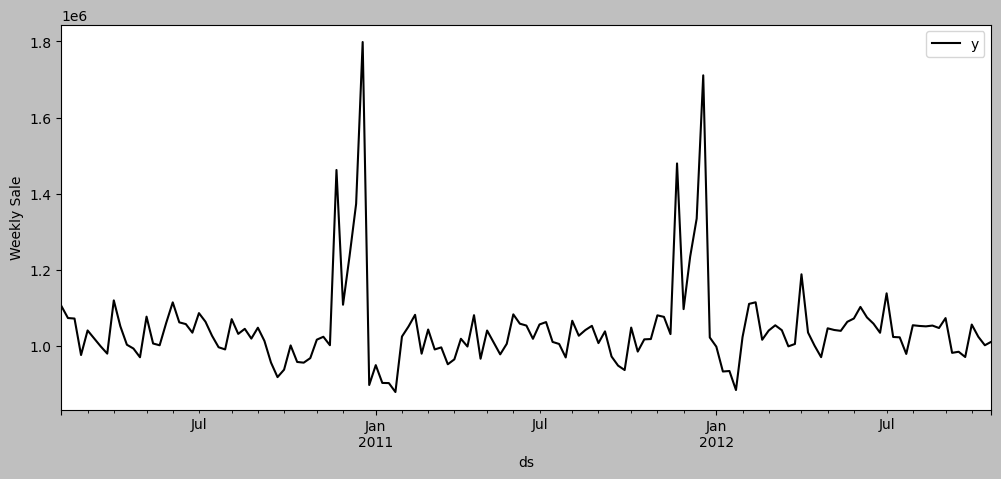

In [102]:
retail_df.plot(x='ds',
               y='y',
              ylabel='Weekly Sale');

In [103]:
test_split = 12
retail_train, retail_test = split_data(retail_df, test_split)

train: 131 , test: 12


In [104]:
retail_train.columns

Index(['ds', 'y', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object')

In [105]:
retail_df

,ds,y,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,1105572.01,0.0,34.04,2.7178,167.730885,8.619
1,2010-02-12,1074148.39,1.0,34.15,2.6940,167.825608,8.619
2,2010-02-19,1072822.08,0.0,37.72,2.6721,167.871686,8.619
3,2010-02-26,977079.36,0.0,39.24,2.6839,167.909657,8.619
4,2010-03-05,1041588.23,0.0,42.92,2.7312,167.947628,8.619
...,...,...,...,...,...,...,...
138,2012-09-28,971886.65,0.0,68.75,3.8546,176.373588,7.237
139,2012-10-05,1057036.43,0.0,65.97,3.8452,176.505052,6.954
140,2012-10-12,1025078.09,0.0,58.34,3.8967,176.636515,6.954
141,2012-10-19,1002720.23,0.0,60.71,3.8800,176.652613,6.954


In [106]:
#pd.concat([holidays[['holiday', 'ds']], us_holidays])

In [107]:
model_retail_v1 = Prophet().fit(retail_train)
retail_future = model_retail_v1.make_future_dataframe(len(retail_test), freq='W-FRI')
retail_forecast_v1 = model_retail_v1.predict(retail_future)

15:26:07 - cmdstanpy - INFO - Chain [1] start processing


15:26:07 - cmdstanpy - INFO - Chain [1] done processing


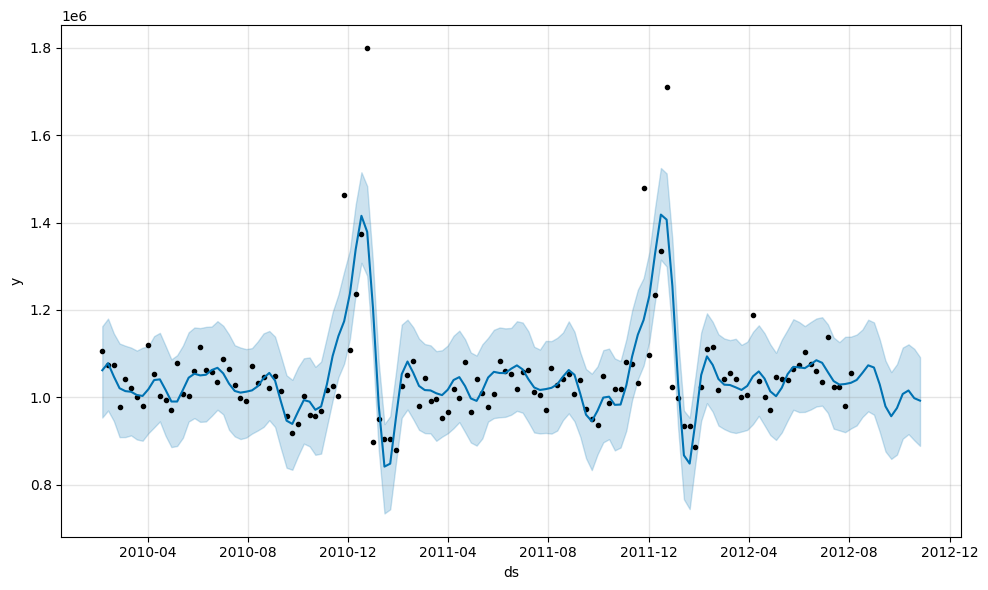

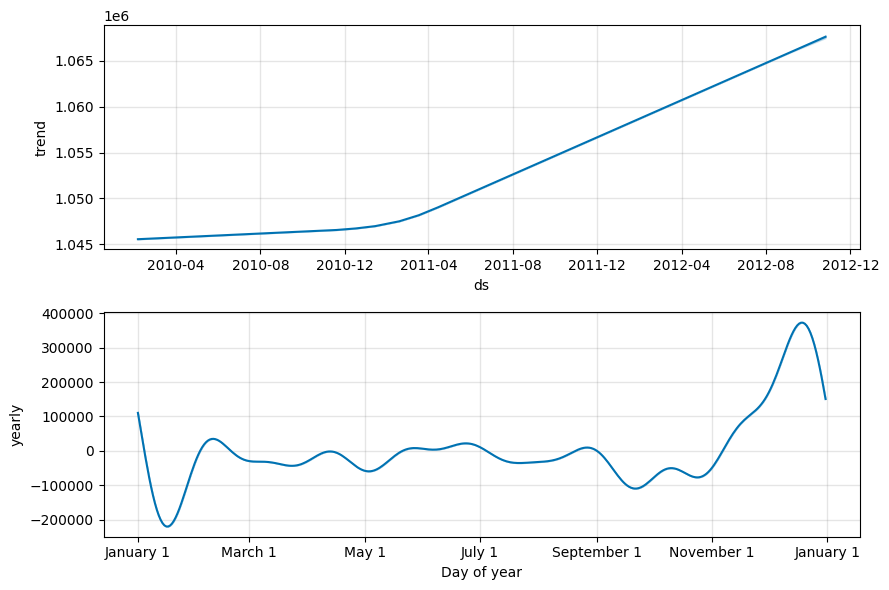

In [108]:
model_retail_v1.plot(retail_forecast_v1);
model_retail_v1.plot_components(retail_forecast_v1);

In [109]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation over the last 12 months
retail_cv_v1 = cross_validation(model_retail_v1,
                                initial='730 days',
                                period='30 days',
                                horizon='12 days')

retail_perf_v1 = performance_metrics(retail_cv_v1)
print(retail_perf_v1[['mae', 'rmse', 'mape']].head())

  0%|          | 0/6 [00:00<?, ?it/s]15:26:08 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing
15:26:08 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:00, 14.11it/s]15:26:08 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing
15:26:08 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing
15:26:08 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:00<00:00, 19.99it/s]15:26:08 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:00<00:00, 19.79it/s]

            mae          rmse      mape
0  12137.358482  12137.358482  0.011933
1    479.642223    479.642223  0.000451
2  37059.131399  37059.131399  0.038147
3  56460.242242  56460.242242  0.057616
4   3379.923493   3379.923493  0.003360


In [110]:
make_holidays_df(year_list=years,
                            country='JO')

NameError: name 'make_holidays_df' is not defined

In [111]:
from prophet.make_holidays import make_holidays_df

holidays = pd.DataFrame({
    'holiday': 'custom holiday',  # Name of the holiday
    'ds': retail_train[retail_train['Holiday_Flag'] == 1]['ds'],
})

years = retail_df['ds'].dt.year.unique().tolist()
us_holidays = make_holidays_df(year_list=years,
                            country='US')

holidays = pd.concat([holidays, us_holidays])
holidays

,holiday,ds
1,custom holiday,2010-02-12
31,custom holiday,2010-09-10
42,custom holiday,2010-11-26
47,custom holiday,2010-12-31
53,custom holiday,2011-02-11
83,custom holiday,2011-09-09
94,custom holiday,2011-11-25
99,custom holiday,2011-12-30
105,custom holiday,2012-02-10
0,New Year's Day,2010-01-01


In [112]:
model_retail_v2 = Prophet(seasonality_mode='additive', holidays=holidays)
model_retail_v2.add_regressor('Temperature')
model_retail_v2.add_regressor('Fuel_Price')
model_retail_v2.add_regressor('CPI')
model_retail_v2.add_regressor('Unemployment')

model_retail_v2.fit(retail_train)

15:26:09 - cmdstanpy - INFO - Chain [1] start processing
15:26:09 - cmdstanpy - INFO - Chain [1] done processing


In [113]:
retail_future_v2 = retail_future.merge(retail_df[['ds',
                                                  'Temperature',
                                                  'Fuel_Price',
                                                  'CPI',
                                                  'Unemployment']],
                                       on='ds', how='left')
retail_future_v2.tail(12)

,ds,Temperature,Fuel_Price,CPI,Unemployment
131,2012-08-10,81.58,3.6329,175.689620,7.237
132,2012-08-17,79.43,3.7205,175.743527,7.237
133,2012-08-24,74.59,3.7596,175.833841,7.237
134,2012-08-31,77.79,3.7691,175.924154,7.237
135,2012-09-07,78.04,3.8426,176.014468,7.237
136,2012-09-14,70.24,3.8520,176.110660,7.237
137,2012-09-21,67.92,3.9079,176.242124,7.237
138,2012-09-28,68.75,3.8546,176.373588,7.237
139,2012-10-05,65.97,3.8452,176.505052,6.954
140,2012-10-12,58.34,3.8967,176.636515,6.954


In [114]:
retail_forecast_v2 = model_retail_v2.predict(retail_future_v2)

In [115]:
retail_forecast_v2.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'CPI', 'CPI_lower', 'CPI_upper', 'Christmas Day', 'Christmas Day_lower',
       'Christmas Day_upper', 'Christmas Day (observed)',
       'Christmas Day (observed)_lower', 'Christmas Day (observed)_upper',
       'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper',
       'Fuel_Price', 'Fuel_Price_lower', 'Fuel_Price_upper',
       'Independence Day', 'Independence Day_lower', 'Independence Day_upper',
       'Independence Day (observed)', 'Independence Day (observed)_lower',
       'Independence Day (observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (observed)', 'New Year's Day (observed)_lower',
   

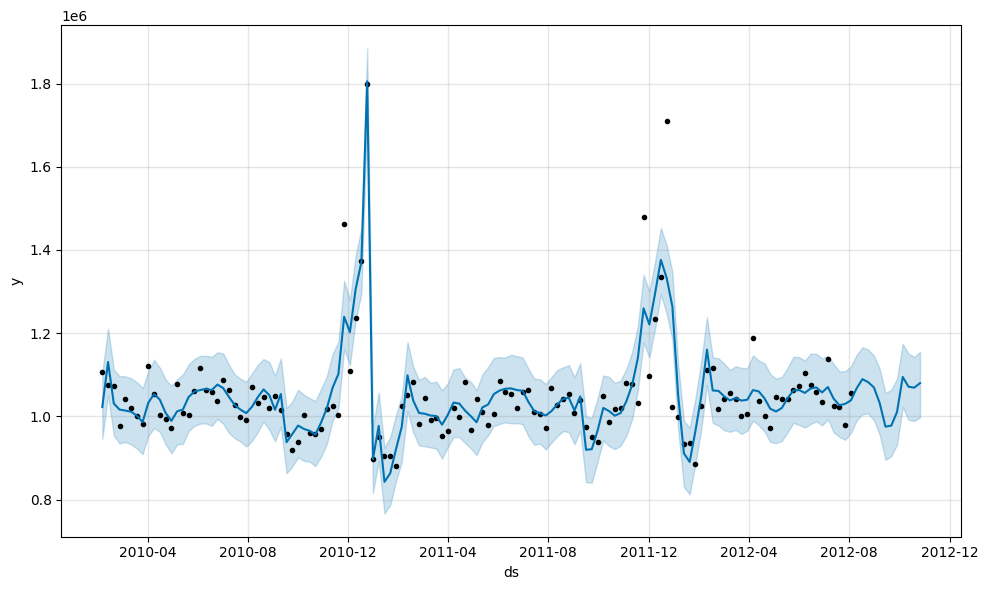

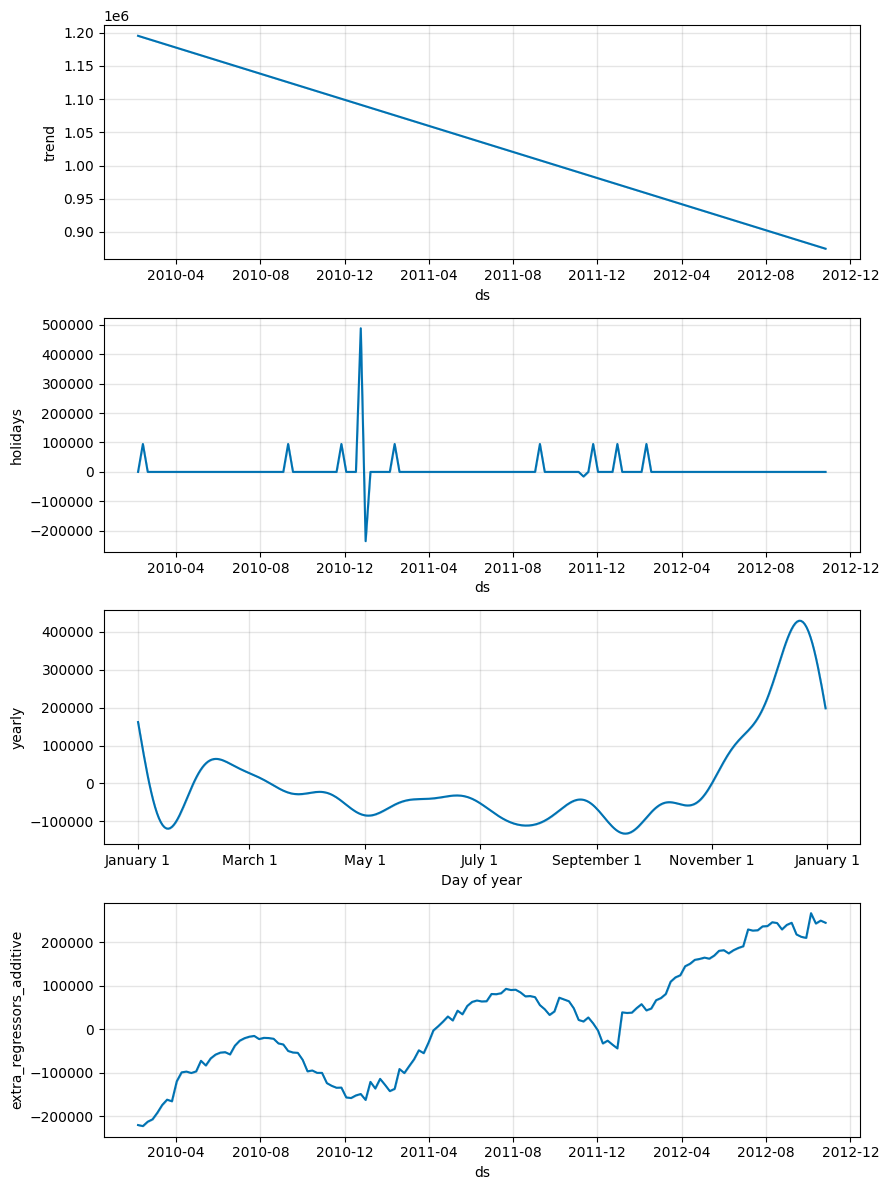

In [116]:
model_retail_v2.plot(retail_forecast_v2);
model_retail_v2.plot_components(retail_forecast_v2);

In [117]:
# Cross-validation over the last 12 months
retail_cv_v2 = cross_validation(model_retail_v2,
                                initial='730 days',
                                period='30 days',
                                horizon='12 days')

# View the cross-validation results
retail_cv_v2.head()

  0%|          | 0/6 [00:00<?, ?it/s]15:26:12 - cmdstanpy - INFO - Chain [1] start processing
15:26:12 - cmdstanpy - INFO - Chain [1] done processing
15:26:12 - cmdstanpy - INFO - Chain [1] start processing
15:26:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:00, 15.44it/s]15:26:12 - cmdstanpy - INFO - Chain [1] start processing
15:26:12 - cmdstanpy - INFO - Chain [1] done processing
15:26:12 - cmdstanpy - INFO - Chain [1] start processing
15:26:12 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:00<00:00, 16.05it/s]15:26:12 - cmdstanpy - INFO - Chain [1] start processing
15:26:12 - cmdstanpy - INFO - Chain [1] done processing
15:26:12 - cmdstanpy - INFO - Chain [1] start processing
15:26:12 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:00<00:00, 16.08it/s]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-02-24,1.059752e+06,967413.133514,1.150596e+06,1017144.59,2012-02-23
1,2012-03-02,1.045661e+06,949858.929206,1.133665e+06,1041356.33,2012-02-23
2,2012-03-30,1.019612e+06,935486.466394,1.103509e+06,1006063.60,2012-03-24
3,2012-04-27,1.010320e+06,926598.290848,1.095434e+06,971484.42,2012-04-23
4,2012-05-04,9.994369e+05,917252.711782,1.082137e+06,1047204.40,2012-04-23


In [118]:
retail_perf_v2 = performance_metrics(retail_cv_v2)
print(retail_perf_v2[['mae', 'rmse', 'mape']].sort_values(by='rmse'))

            mae          rmse      mape
6   4304.278009   4304.278009  0.004133
9   7908.117728   7908.117728  0.007494
1  11644.688029  11644.688029  0.010941
4  13548.222141  13548.222141  0.013467
5  17795.402974  17795.402974  0.017185
7  23766.452119  23766.452119  0.022151
2  38835.131879  38835.131879  0.039975
0  42607.265030  42607.265030  0.041889
8  47767.455981  47767.455981  0.045614
3  60584.389103  60584.389103  0.061825


In [119]:
retail_perf_v2.mean()[1:-1]

mse      1055748338.631685
rmse          26876.140299
mae           26876.140299
mape              0.026468
mdape             0.026468
smape             0.026233
dtype: object

In [120]:
print(retail_perf_v1[['mae', 'rmse', 'mape']].sort_values(by='rmse'))

            mae          rmse      mape
1    479.642223    479.642223  0.000451
4   3379.923493   3379.923493  0.003360
0  12137.358482  12137.358482  0.011933
7  12707.491106  12707.491106  0.011844
9  19024.837055  19024.837055  0.018029
6  25395.991510  25395.991510  0.024387
2  37059.131399  37059.131399  0.038147
5  37666.829161  37666.829161  0.036376
8  51040.744763  51040.744763  0.048740
3  56460.242242  56460.242242  0.057616


In [121]:
retail_perf_v1.mean()[1:-1]

mse      991243636.944191
rmse         25535.219143
mae          25535.219143
mape             0.025088
mdape            0.025088
smape            0.024959
dtype: object

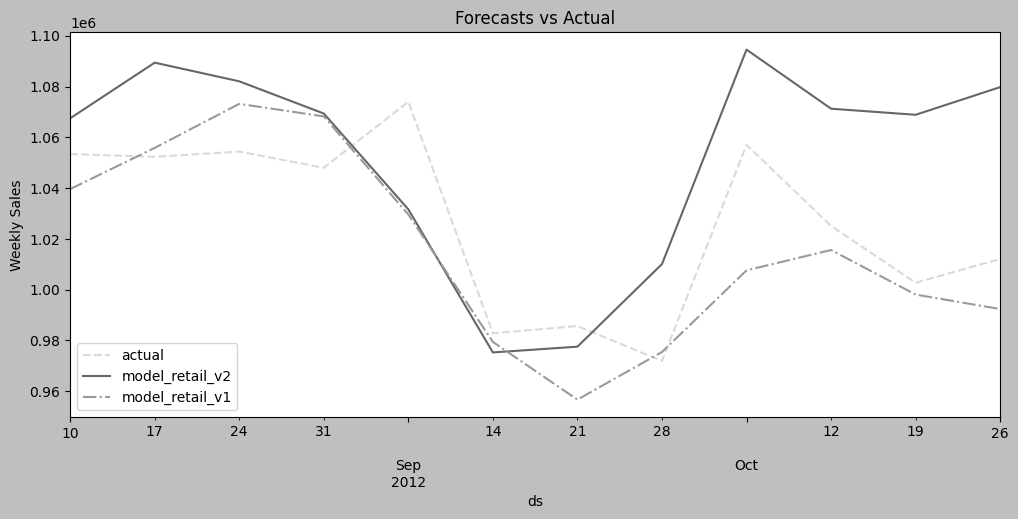

In [122]:
ax = retail_test.plot(x='ds',
                      y='y',
                      style='--',
                      label='actual',
                      alpha=0.15,
                      title='Forecasts vs Actual',
                      ylabel='Weekly Sales')
retail_forecast_v2.tail(12).plot(x='ds', y='yhat', ax=ax,
                                 label='model_retail_v2',
                                 style='-')
retail_forecast_v1.tail(12).plot(x='ds', y='yhat', ax=ax,
                                 label='model_retail_v1',
                                 style='-.');

## Part 4: Time Series Forecasting with Theta Method

The Theta method is a simple yet powerful forecasting technique based on exponential smoothing. It decomposes the time series into two theta lines:

- **Theta line 1 (θ₁)**: The original series (trend + seasonal)
- **Theta line 2 (θ₂)**: Deseasonalized and detrended series

The forecast combines these lines with different weights, typically θ₁ + θ₂ - 2θ₀ where θ₀ is the naive forecast.

### 4.1 Theta Model Implementation

In [123]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
milk_file = Path('milk_production.csv')
milk = pd.read_csv(milk_file,
                   parse_dates=['month'],
                   index_col='month')
milk.head()

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [124]:
test_split = 12
train, test = split_data(milk, test_split)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

train: 156 , test: 12
Train: (156, 1)
Test: (12, 1)


<Axes: xlabel='month'>

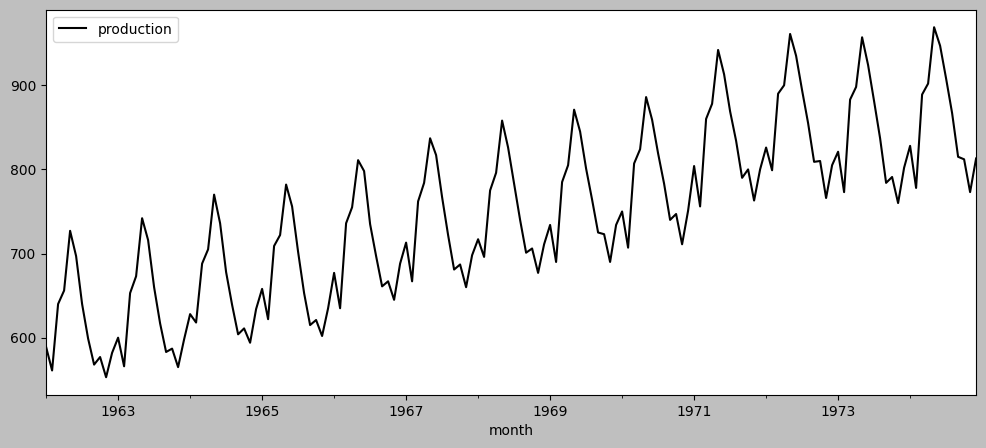

In [125]:
train.plot()

In [126]:
from statsmodels.tsa.forecasting.theta import ThetaModel

In [127]:
model = ThetaModel(train,
                  deseasonalize=True)

In [128]:
results = model.fit()

### 4.2 Model Fitting and Parameter Estimation

The Theta method fits the model by:
1. **Deseasonalizing** the series (if deseasonalize=True)
2. **Estimating trend** using linear regression on the theta lines
3. **Optimizing theta parameter** to minimize forecast error

The key parameter is **theta (θ)** which controls the weighting between different components:
- θ = 0: Simple exponential smoothing (SES)
- θ = 1: Linear trend extrapolation
- θ = 2: Damped trend (commonly optimal)

In [129]:
print(results.summary())

                              ThetaModel Results                              
Dep. Variable:             production   No. Observations:                  156
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Thu, 23 Oct 2025   Deseas. Method:         Multiplicative
Time:                        15:26:22   Period:                             12
Sample:                    01-01-1962                                         
                         - 12-01-1974                                         
  Parameter Estimates   
          Parameters    
------------------------
b0     1.820835909069458
alpha 0.9997934075172108
------------------------


In [130]:
results.params

b0       1.820836
alpha    0.999793
dtype: float64

In [131]:
n = test.shape[0]

forecast = results.forecast(steps=n, theta=2)
forecast_df = pd.Series(forecast.tolist(), index=test.index)
print(forecast_df)

month
1975-01-01    842.763868
1975-02-01    798.584222
1975-03-01    906.159891
1975-04-01    925.102611
1975-05-01    996.154497
1975-06-01    964.758678
1975-07-01    905.989855
1975-08-01    856.248938
1975-09-01    808.418465
1975-10-01    813.948492
1975-11-01    780.025236
1975-12-01    823.296964
dtype: float64


### 4.3 Generating Forecasts and Evaluation

The Theta method generates forecasts by combining the theta lines with optimized weights. We'll compare the forecasts with actual values and visualize the results.

Key evaluation metrics for time series forecasting:
- **MAE (Mean Absolute Error)**: Average absolute difference between predicted and actual
- **RMSE (Root Mean Square Error)**: Square root of average squared errors (penalizes large errors)
- **MAPE (Mean Absolute Percentage Error)**: Percentage error relative to actual values

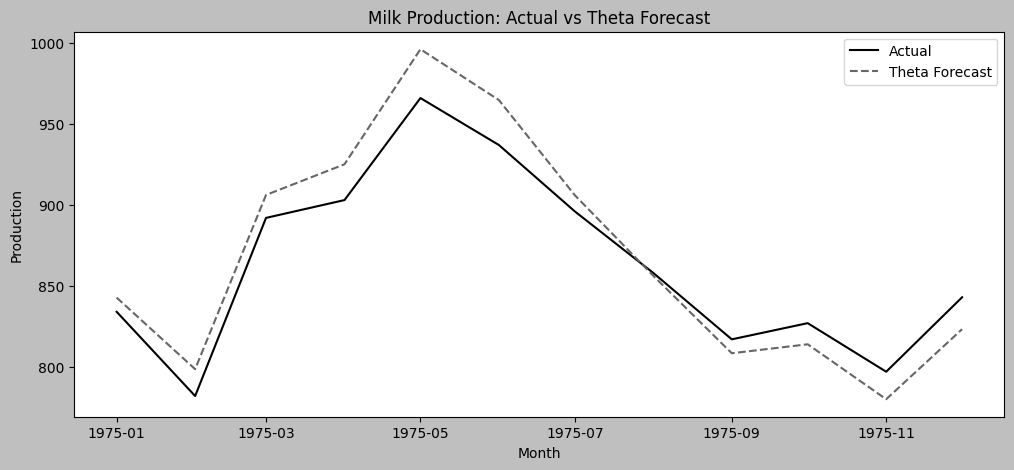

In [132]:
idx = test.index
plt.plot(idx, test['production'], label='Actual')
plt.plot(idx, forecast_df,
         label='Theta Forecast',
         linestyle='--')
plt.title('Milk Production: Actual vs Theta Forecast')
plt.xlabel('Month')
plt.ylabel('Production')
plt.legend()
plt.show()

In [133]:
components = results.forecast_components(steps=n)
print(components)

         trend        ses  seasonal
157   1.821212  862.63851  0.975930
158   3.642048  862.63851  0.923796
159   5.462884  862.63851  1.047136
160   7.283720  862.63851  1.067902
161   9.104556  862.63851  1.148714
162  10.925392  862.63851  1.111344
163  12.746228  862.63851  1.042552
164  14.567064  862.63851  0.984282
165  16.387899  862.63851  0.928328
166  18.208735  862.63851  0.933702
167  20.029571  862.63851  0.893855
168  21.850407  862.63851  0.942458


### 4.4 Component Analysis and Uncertainty

The Theta method decomposes forecasts into interpretable components:
- **Trend**: Long-term direction of the series
- **SES (Simple Exponential Smoothing)**: Level component
- **Seasonal**: Periodic patterns

Understanding these components helps in:
- **Model interpretation**: Why the model makes certain predictions
- **Uncertainty quantification**: Prediction intervals for decision making
- **Business insights**: Understanding what drives the forecasts

<Axes: title={'center': 'Trend Component'}>

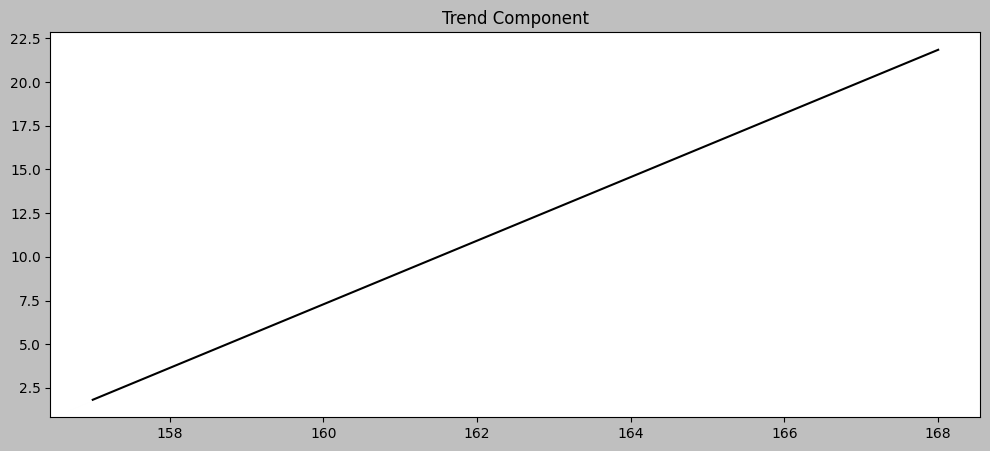

In [134]:
components['trend'].plot(title='Trend Component')

<Axes: title={'center': 'SES Component'}>

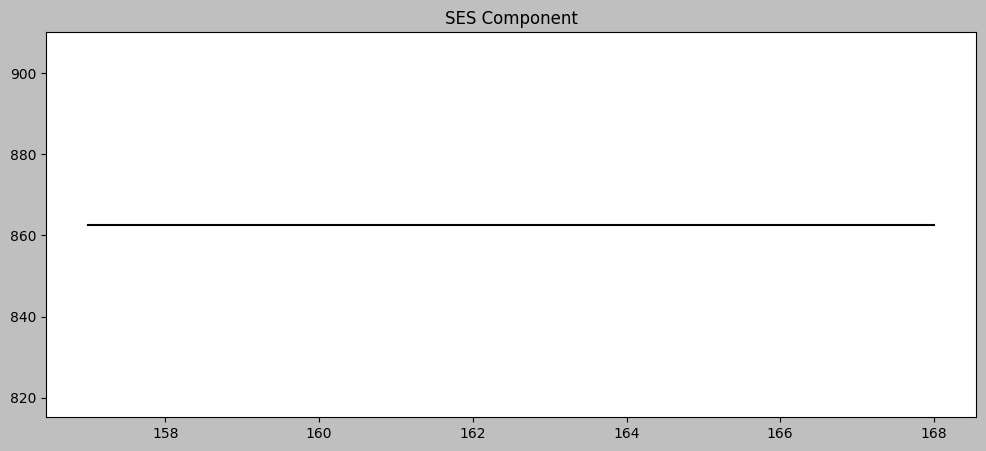

In [135]:
components['ses'].plot(title='SES Component')

<Axes: title={'center': 'Seasoanl Component'}>

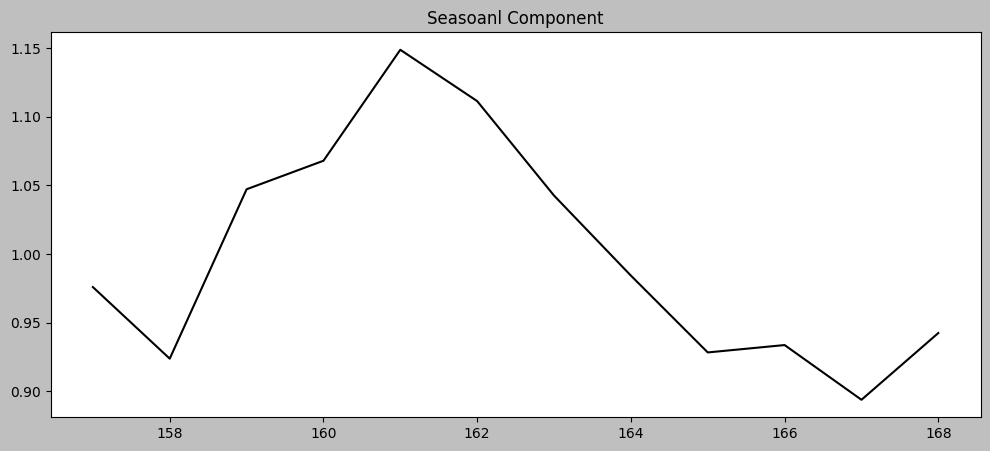

In [136]:
components['seasonal'].plot(title='Seasoanl Component')

In [137]:
intervals = results.prediction_intervals(steps=n, theta=2)
print(intervals)

          lower        upper
157  754.502242   931.025494
158  673.763432   923.405012
159  753.286268  1059.033514
160  748.579356  1101.625866
161  798.795498  1193.513497
162  748.562727  1180.954630
163  672.471537  1139.508172
164  606.607356  1105.890520
165  543.633581  1073.203348
166  534.840718  1093.056265
167  487.294533  1072.755939
168  517.549716  1129.044211


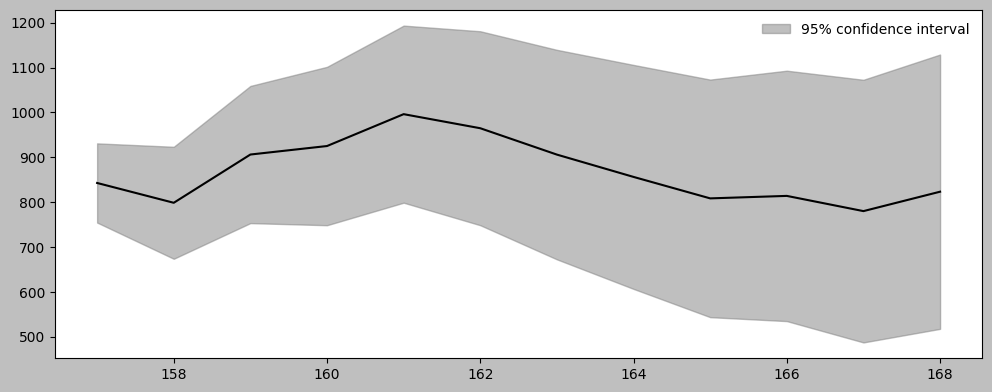

In [138]:
results.plot_predict(steps=n, theta=2, figsize=(10,4), alpha=0.05);

## Part 5: Automated Time Series Forecasting with StatsForecast

StatsForecast provides a unified interface for multiple forecasting models with automatic parameter selection. It includes:

- **AutoARIMA**: Automatic ARIMA model selection
- **AutoETS**: Automatic Exponential Smoothing State Space model
- **AutoTheta**: Automatic Theta method
- **And many more**: NeuralForecast models, statistical models, ML models

Key advantages:
- **Scalable**: Handles thousands of time series efficiently
- **Automatic**: No manual parameter tuning required
- **Probabilistic**: Provides prediction intervals
- **Production-ready**: Optimized for performance

### 5.1 Setting Up Automated Forecasting

In [139]:
!uv pip install -Uq statsforecast

In [140]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA,
                                  AutoETS,
                                  AutoTheta)
import matplotlib.pyplot as plt
from pathlib import Path

In [141]:
import statsforecast
statsforecast.__version__

'2.0.2'

In [142]:
!python --version

Python 3.12.11


In [143]:
milk_file = Path('milk_production.csv')
milk = pd.read_csv(milk_file, parse_dates=['month'])
milk.columns = ['ds', 'y']
milk['unique_id'] = 'milk'

test_split = 12
train, test = split_data(milk, test_split)

# print(f'Train: {train.shape}')
# print(f'Test: {test.shape}')


train: 156 , test: 12


In [144]:
print(milk.head())

          ds    y unique_id
0 1962-01-01  589      milk
1 1962-02-01  561      milk
2 1962-03-01  640      milk
3 1962-04-01  656      milk
4 1962-05-01  727      milk


In [145]:
plt.style.use('grayscale')

plt.rc("figure", figsize=(16, 5))

In [146]:
sl = 12
models = [AutoARIMA(season_length=sl),
          AutoETS(season_length=sl),
          AutoTheta(season_length=sl)]


sf = StatsForecast(
    models = models,
    freq = 'MS'
)
sf.fit(train)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta])

### 5.2 Model Training and Automatic Parameter Selection

StatsForecast automatically handles:
- **Model selection**: Chooses optimal parameters for each algorithm
- **Seasonal decomposition**: Automatically detects seasonal patterns
- **Parameter optimization**: Uses statistical criteria to find best settings

The three models we're using:
- **AutoARIMA**: Finds optimal ARIMA(p,d,q) parameters automatically
- **AutoETS**: Selects best exponential smoothing method (additive/multiplicative)
- **AutoTheta**: Optimizes theta parameter for best performance

Each model is trained independently and can be compared for accuracy.

In [147]:
# sf.fit(train,
#       id_col = 'unique_id',
#       time_col = 'month',
#       target_col = 'production')

### 5.2 Model Evaluation and Comparison

StatsForecast provides comprehensive evaluation tools:

- **Cross-validation**: Time series aware CV with rolling windows
- **Multiple metrics**: MAE, MSE, RMSE, MAPE, etc.
- **Model comparison**: Automatic best model selection
- **Confidence intervals**: Quantifies forecast uncertainty

The evaluation process ensures models are tested on out-of-sample data while respecting temporal order.

In [148]:
n = test.shape[0]

forecast_df = sf.predict(h=n, level=[80,95])

### 5.3 Generating Predictions and Model Inspection

StatsForecast provides two main prediction methods:
- **predict()**: Fast predictions using stored fitted models
- **forecast()**: More flexible predictions with additional options

After fitting, we can inspect:
- **Model parameters**: What settings each algorithm chose
- **Fitted values**: How well the model captured historical patterns
- **Prediction intervals**: Uncertainty bounds around forecasts

This transparency helps understand model behavior and build trust in automated predictions.

In [149]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   unique_id        12 non-null     object        
 1   ds               12 non-null     datetime64[ns]
 2   AutoARIMA        12 non-null     float32       
 3   AutoARIMA-lo-95  12 non-null     float32       
 4   AutoARIMA-lo-80  12 non-null     float32       
 5   AutoARIMA-hi-80  12 non-null     float32       
 6   AutoARIMA-hi-95  12 non-null     float32       
 7   AutoETS          12 non-null     float32       
 8   AutoETS-lo-95    12 non-null     float32       
 9   AutoETS-lo-80    12 non-null     float32       
 10  AutoETS-hi-80    12 non-null     float32       
 11  AutoETS-hi-95    12 non-null     float32       
 12  AutoTheta        12 non-null     float32       
 13  AutoTheta-lo-80  12 non-null     float32       
 14  AutoTheta-hi-80  12 non-null     float32    

In [150]:
sf.fitted_

array([[AutoARIMA, AutoETS, AutoTheta]], dtype=object)

### 5.3.1 Inspecting Fitted Models

After training, StatsForecast stores the fitted models for inspection. This allows us to:
- **Check model parameters**: See what settings were automatically chosen
- **Understand model complexity**: Compare parameter counts across models
- **Debug issues**: Identify why certain models might perform differently

The fitted models contain detailed information about the selected parameters and internal state of each algorithm.

In [151]:
model_list = [str(models) for models in sf.models]
for i, m in enumerate(model_list):
    print(f'Model {i} = {m}  ')
    print(list(sf.fitted_[0][i].model_.keys()))

Model 0 = AutoARIMA  
['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'xreg', 'bic', 'aicc', 'ic', 'x', 'lambda']
Model 1 = AutoETS  
['loglik', 'aic', 'bic', 'aicc', 'mse', 'amse', 'fit', 'residuals', 'components', 'm', 'nstate', 'fitted', 'states', 'par', 'sigma2', 'n_params', 'method', 'actual_residuals']
Model 2 = AutoTheta  
['mse', 'amse', 'fit', 'residuals', 'm', 'states', 'par', 'n', 'modeltype', 'mean_y', 'decompose', 'decomposition_type', 'seas_forecast', 'fitted']


In [152]:
# AutoARIMA model
sf.fitted_[0][0].model_.get('arma')

(2, 0, 0, 1, 12, 0, 1)

In [153]:
# AutoETS method
sf.fitted_[0][1].model_.get('method')

'ETS(A,A,A)'

In [154]:
# AutoTheta params
sf.fitted_[0][2].model_.get('par')

{'initial_smoothed': np.float64(-1166.893868645345),
 'alpha': np.float64(0.9899999999999982),
 'theta': np.float64(10.53931199119343)}

In [155]:
# forecast_df = forecast_df.reset_index()

In [156]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   unique_id        12 non-null     object        
 1   ds               12 non-null     datetime64[ns]
 2   AutoARIMA        12 non-null     float32       
 3   AutoARIMA-lo-95  12 non-null     float32       
 4   AutoARIMA-lo-80  12 non-null     float32       
 5   AutoARIMA-hi-80  12 non-null     float32       
 6   AutoARIMA-hi-95  12 non-null     float32       
 7   AutoETS          12 non-null     float32       
 8   AutoETS-lo-95    12 non-null     float32       
 9   AutoETS-lo-80    12 non-null     float32       
 10  AutoETS-hi-80    12 non-null     float32       
 11  AutoETS-hi-95    12 non-null     float32       
 12  AutoTheta        12 non-null     float32       
 13  AutoTheta-lo-80  12 non-null     float32       
 14  AutoTheta-hi-80  12 non-null     float32    

In [157]:
arima_cols = ['ds','AutoARIMA', 'AutoARIMA-lo-95', 'AutoARIMA-hi-95']
print(forecast_df[arima_cols].head())

          ds   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0 1975-01-01  840.524292       826.148376       854.900146
1 1975-02-01  797.604919       779.865784       815.343994
2 1975-03-01  904.082092       883.606018       924.558228
3 1975-04-01  919.784912       897.272827       942.297058
4 1975-05-01  984.401978       960.269409      1008.534607


In [158]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sf.plot(test, forecast_df)
plt.tight_layout()
plt.show();

<Figure size 1200x600 with 0 Axes>

### 5.3.2 Visualization and Model Comparison

Effective visualization is crucial for:
- **Model comparison**: Seeing which model performs best visually
- **Uncertainty communication**: Showing prediction intervals to stakeholders
- **Pattern recognition**: Identifying where models struggle or excel

StatsForecast provides built-in plotting that automatically handles:
- **Multiple models**: Overlaying forecasts from different algorithms
- **Confidence intervals**: Displaying uncertainty bands
- **Interactive exploration**: Zooming and panning for detailed analysis

In [159]:
forecast_df.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95,AutoETS,AutoETS-lo-95,AutoETS-lo-80,AutoETS-hi-80,AutoETS-hi-95,AutoTheta,AutoTheta-lo-80,AutoTheta-hi-80,AutoTheta-lo-95,AutoTheta-hi-95
0,milk,1975-01-01,840.524292,826.148376,831.124390,849.924133,854.900146,846.591675,829.774780,835.595703,857.587646,863.408569,843.520935,834.200134,854.836365,831.116516,858.294250
1,milk,1975-02-01,797.604919,779.865784,786.005920,809.203918,815.343994,810.539246,792.589661,798.802612,822.275818,828.488770,799.982239,786.695740,813.473389,780.004822,818.687561
2,milk,1975-03-01,904.082092,883.606018,890.693481,917.470703,924.558228,904.197937,885.180481,891.763123,916.632751,923.215332,908.517029,888.403381,926.460083,878.789978,934.822388
3,milk,1975-04-01,919.784912,897.272827,905.065063,934.504822,942.297058,921.789368,901.758545,908.691956,934.886841,941.820190,928.294250,907.159363,945.574341,896.812439,959.485291
4,milk,1975-05-01,984.401978,960.269409,968.622559,1000.181458,1008.534607,985.821167,964.823486,972.091553,999.550781,1006.818848,1000.434998,974.819946,1024.966553,959.872253,1038.424683


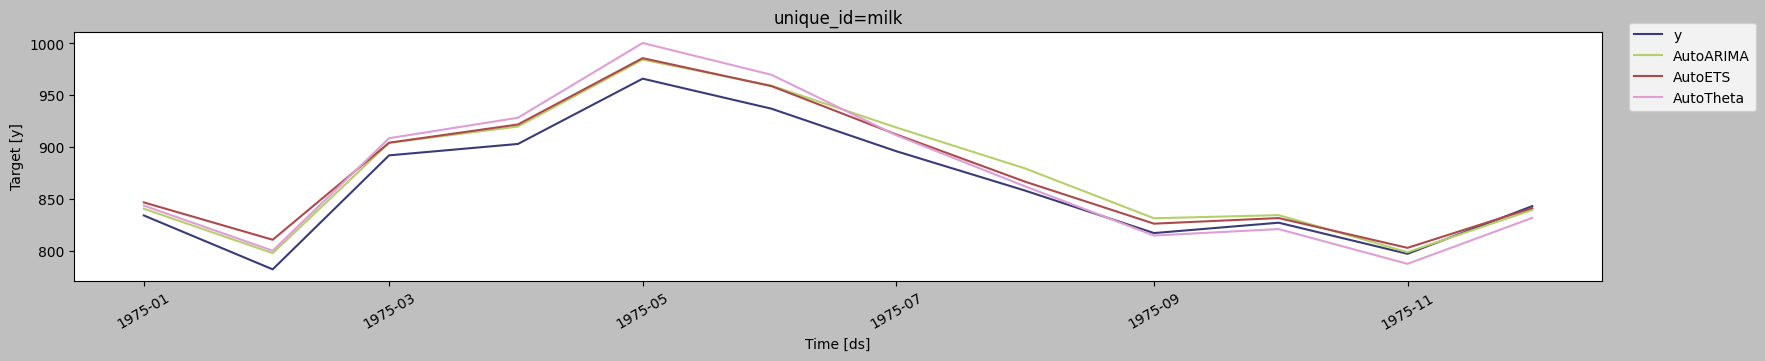

In [160]:
sf.plot(test, forecast_df)

In [161]:
sf.fitted_[0]

array([AutoARIMA, AutoETS, AutoTheta], dtype=object)

In [162]:
sf.fitted_[0,0].model_['arma']

(2, 0, 0, 1, 12, 0, 1)

In [163]:
sf.fitted_[0,2].model_['par']

{'initial_smoothed': np.float64(-1166.893868645345),
 'alpha': np.float64(0.9899999999999982),
 'theta': np.float64(10.53931199119343)}

In [164]:
sf.fitted_[0,1].model_['par']

array([ 3.72695678e-01,  4.55966814e-04,  4.90210842e-02,             nan,
        6.03907287e+02,  1.95409176e+00, -4.50990810e+01, -8.02254540e+01,
       -5.07111993e+01, -5.48733207e+01, -1.61115472e+01,  3.60823545e+01,
        8.40659294e+01,  1.14468617e+02,  5.13095161e+01,  3.42813569e+01,
       -5.50132584e+01, -1.81739133e+01])

AutoARIMA


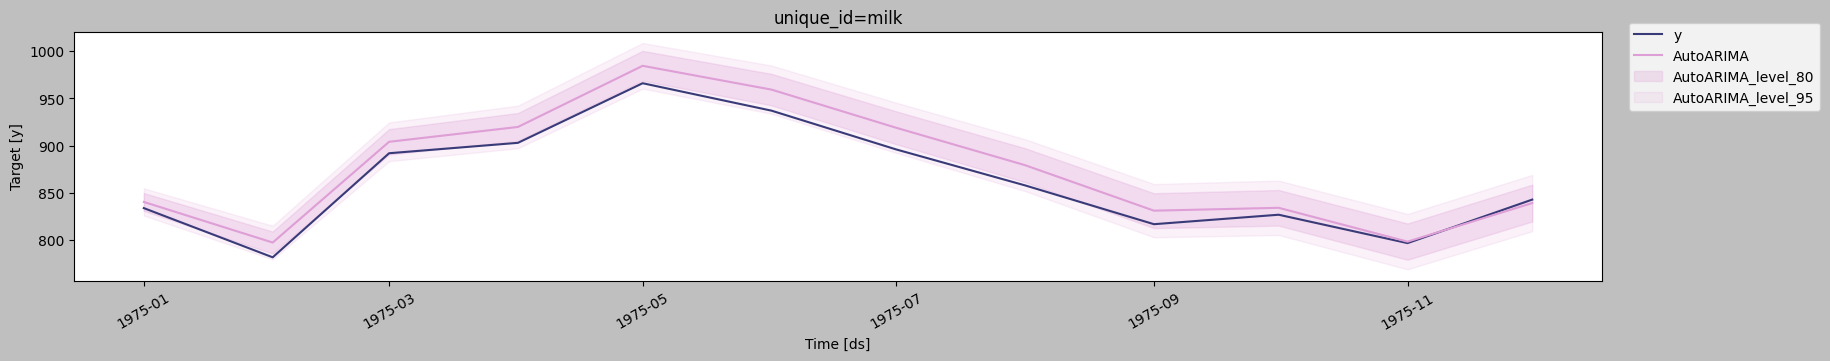

AutoETS


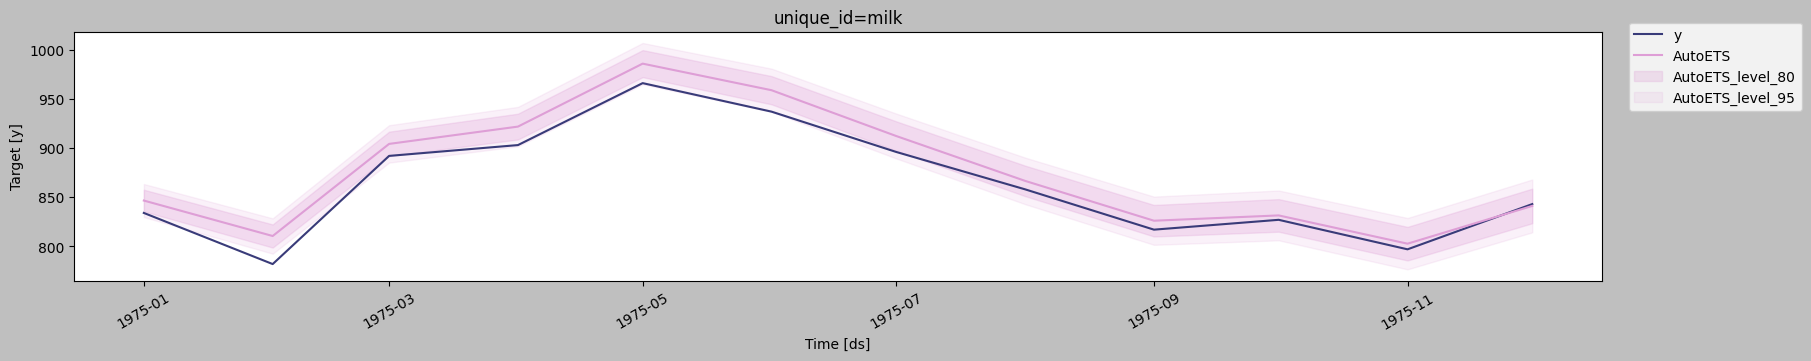

AutoTheta


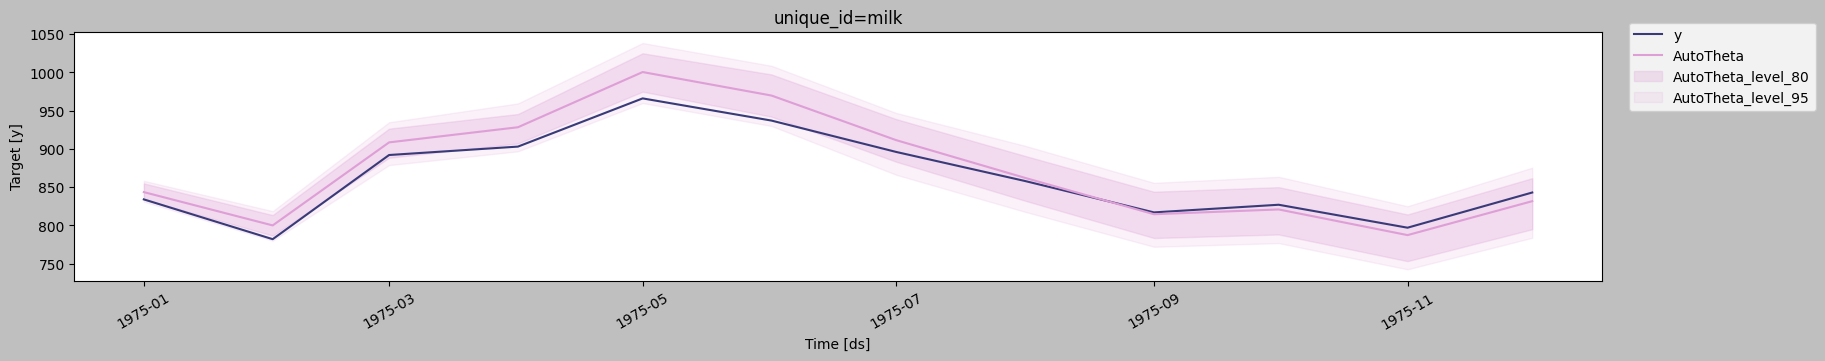

In [165]:
for model in sf.models:
    print(model)
    fig = sf.plot(test, forecast_df, models=[str(model)], level=[80,95])
    display(fig)

In [166]:
#final = test.merge(forecast_df, how='inner', on='ds')

In [167]:
# h=12 forecast horizon is set to 12 months
# step_size = 12, each step size between each cross-validation window is 12 months.
# n_window=1 only one-cross validation window is used
crossvalidation_df = sf.cross_validation(
    df=milk,
    h=12,
    step_size=12,
    n_windows=4
)

### 5.4 Cross-Validation and Model Comparison

Cross-validation for time series uses a rolling forecast approach:
- **h**: Forecast horizon (how far ahead to predict)
- **step_size**: How much to advance each window
- **n_windows**: Number of CV folds

This approach:
- **Respects temporal order**: Never uses future data to predict past
- **Tests different scenarios**: Various training window sizes
- **Provides robust metrics**: Average performance across multiple periods

The evaluation compares all models simultaneously, helping identify the most accurate approach for your specific data.

In [169]:
crossvalidation_df.head()

,unique_id,ds,cutoff,y,AutoARIMA,AutoETS,AutoTheta
0,milk,1972-01-01,1971-12-01,826.0,835.644897,816.135010,833.166870
1,milk,1972-02-01,1971-12-01,799.0,792.584961,782.166321,789.943298
2,milk,1972-03-01,1971-12-01,890.0,891.021484,870.334045,897.904968
3,milk,1972-04-01,1971-12-01,900.0,909.428711,887.983398,919.605774
4,milk,1972-05-01,1971-12-01,961.0,972.341736,951.904297,993.479309


In [170]:
print(crossvalidation_df.head())

  unique_id         ds     cutoff      y   AutoARIMA     AutoETS   AutoTheta
0      milk 1972-01-01 1971-12-01  826.0  835.644897  816.135010  833.166870
1      milk 1972-02-01 1971-12-01  799.0  792.584961  782.166321  789.943298
2      milk 1972-03-01 1971-12-01  890.0  891.021484  870.334045  897.904968
3      milk 1972-04-01 1971-12-01  900.0  909.428711  887.983398  919.605774
4      milk 1972-05-01 1971-12-01  961.0  972.341736  951.904297  993.479309


In [171]:
crossvalidation_df.shape

(48, 7)

In [172]:
print(crossvalidation_df[['ds', 'cutoff', 'y', 'AutoARIMA']])

           ds     cutoff      y   AutoARIMA
0  1972-01-01 1971-12-01  826.0  835.644897
1  1972-02-01 1971-12-01  799.0  792.584961
2  1972-03-01 1971-12-01  890.0  891.021484
3  1972-04-01 1971-12-01  900.0  909.428711
4  1972-05-01 1971-12-01  961.0  972.341736
5  1972-06-01 1971-12-01  935.0  944.871765
6  1972-07-01 1971-12-01  894.0  900.721252
7  1972-08-01 1971-12-01  855.0  863.671265
8  1972-09-01 1971-12-01  809.0  821.674866
9  1972-10-01 1971-12-01  810.0  828.426331
10 1972-11-01 1971-12-01  766.0  794.366455
11 1972-12-01 1971-12-01  805.0  832.953369
12 1973-01-01 1972-12-01  821.0  836.856384
13 1973-02-01 1972-12-01  773.0  801.292236
14 1973-03-01 1972-12-01  883.0  897.255981
15 1973-04-01 1972-12-01  898.0  913.246033
16 1973-05-01 1972-12-01  957.0  975.994324
17 1973-06-01 1972-12-01  924.0  949.769348
18 1973-07-01 1972-12-01  881.0  907.011536
19 1973-08-01 1972-12-01  837.0  869.415710
20 1973-09-01 1972-12-01  784.0  826.481140
21 1973-10-01 1972-12-01  791.0 

In [173]:
from utilsforecast.losses import mse, mape, rmse, mae
from utilsforecast.evaluation import evaluate

In [174]:
metrics = [mae, mse, rmse, mape]

evaluation = evaluate(
    crossvalidation_df,
    metrics=metrics,
    models=model_list,
    # level=[80, 95]
)
print(evaluation.drop(columns='unique_id'))

  metric   AutoARIMA     AutoETS   AutoTheta
0    mae   15.087765   15.322071   15.726682
1    mse  338.023010  334.270325  344.069244
2   rmse   18.385403   18.283062   18.549103
3   mape    0.018029    0.018218    0.018136


In [175]:
evaluation['Best_Model'] = evaluation[['AutoARIMA',
                                       'AutoETS',
                                       'AutoTheta']].idxmin(axis=1)
print(evaluation.drop(columns='unique_id'))

  metric   AutoARIMA     AutoETS   AutoTheta Best_Model
0    mae   15.087765   15.322071   15.726682  AutoARIMA
1    mse  338.023010  334.270325  344.069244    AutoETS
2   rmse   18.385403   18.283062   18.549103    AutoETS
3   mape    0.018029    0.018218    0.018136  AutoARIMA


In [176]:
sf.fitted_[0][0].model_.get('arma')

(2, 0, 0, 1, 12, 0, 1)

In [177]:
test.shape

(12, 3)

In [178]:
train.shape

(156, 3)

In [179]:
milk['ds'].dt.year.unique()

array([1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975], dtype=int32)

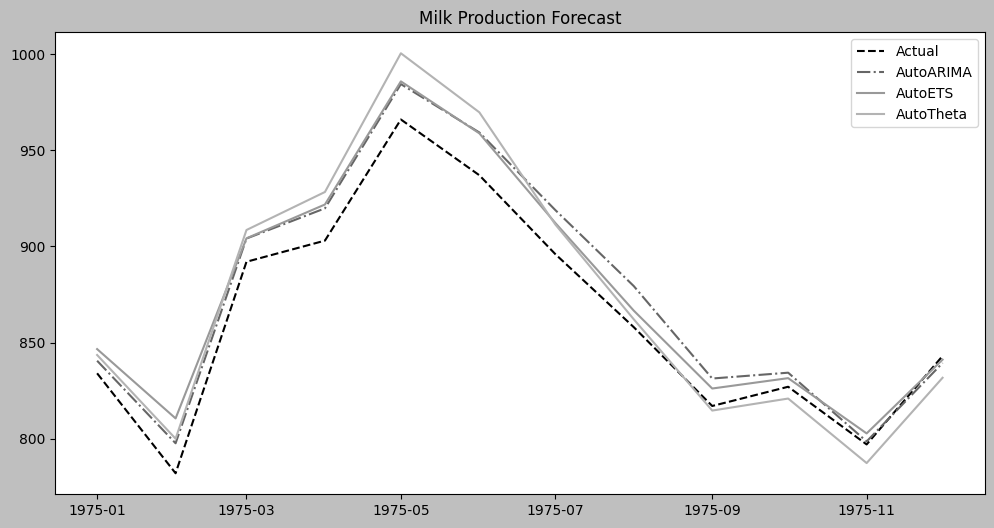

In [180]:
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], linestyle='--', label='Actual')
plt.plot(forecast_df['ds'], forecast_df['AutoARIMA'], linestyle='-.', label='AutoARIMA')
plt.plot(forecast_df['ds'], forecast_df['AutoETS'], label='AutoETS')
plt.plot(forecast_df['ds'], forecast_df['AutoTheta'], label='AutoTheta')
plt.legend()
plt.title('Milk Production Forecast')
plt.show()

### 5.3 Forecasting with Exogenous Variables

Many real-world forecasting problems involve external factors that influence the target variable. StatsForecast supports exogenous regressors that can improve forecast accuracy by incorporating:

- **Economic indicators**: GDP, inflation, unemployment rates
- **Weather data**: Temperature, precipitation, seasonality effects
- **Marketing variables**: Promotions, advertising spend
- **Business metrics**: Inventory levels, competitor activity

The framework automatically handles:
- **Feature engineering**: Lags, rolling statistics, seasonal decompositions
- **Missing data**: Robust imputation methods
- **Multivariate forecasting**: Multiple related time series

In [181]:
milk_file = Path('cpi.csv')
milk = pd.read_csv(milk_file, parse_dates=['month'])

### 5.5 Advanced Forecasting: Incorporating Exogenous Variables

Many forecasting problems benefit from external information. Exogenous variables can include:

- **Economic indicators**: Interest rates, inflation, GDP growth
- **Weather data**: Temperature, precipitation affecting demand
- **Marketing spend**: Advertising budgets, promotional activities
- **Competitor actions**: Market share changes, pricing strategies

StatsForecast handles exogenous variables by:
- **Automatic feature engineering**: Creates lags and interactions
- **Missing value handling**: Robust to incomplete external data
- **Scalable processing**: Efficient with large numbers of regressors

The improvement from adding exogenous variables demonstrates the value of incorporating domain knowledge into forecasting models.

In [182]:
milk.head()

,month,production,cpi
0,1962-01-01,589,30.04
1,1962-02-01,561,30.11
2,1962-03-01,640,30.17
3,1962-04-01,656,30.21
4,1962-05-01,727,30.24


In [183]:
milk.columns = ['ds', 'y', 'X']
milk['unique_id'] = 'milk'
milk.head()

,ds,y,X,unique_id
0,1962-01-01,589,30.04,milk
1,1962-02-01,561,30.11,milk
2,1962-03-01,640,30.17,milk
3,1962-04-01,656,30.21,milk
4,1962-05-01,727,30.24,milk


In [184]:
print(milk.head())

          ds    y      X unique_id
0 1962-01-01  589  30.04      milk
1 1962-02-01  561  30.11      milk
2 1962-03-01  640  30.17      milk
3 1962-04-01  656  30.21      milk
4 1962-05-01  727  30.24      milk


In [185]:
train, test = split_data(milk, 12)

train: 156 , test: 12


In [186]:
train

,ds,y,X,unique_id
0,1962-01-01,589,30.04,milk
1,1962-02-01,561,30.11,milk
2,1962-03-01,640,30.17,milk
3,1962-04-01,656,30.21,milk
4,1962-05-01,727,30.24,milk
...,...,...,...,...
151,1974-08-01,867,49.90,milk
152,1974-09-01,815,50.60,milk
153,1974-10-01,812,51.00,milk
154,1974-11-01,773,51.50,milk


In [187]:
X_test = test.drop(columns=['y'])
X_test

,ds,X,unique_id
156,1975-01-01,52.3,milk
157,1975-02-01,52.6,milk
158,1975-03-01,52.8,milk
159,1975-04-01,53.0,milk
160,1975-05-01,53.1,milk
161,1975-06-01,53.5,milk
162,1975-07-01,54.0,milk
163,1975-08-01,54.2,milk
164,1975-09-01,54.6,milk
165,1975-10-01,54.9,milk


In [188]:
Y_test = test.drop(columns=['X'])
Y_test

,ds,y,unique_id
156,1975-01-01,834,milk
157,1975-02-01,782,milk
158,1975-03-01,892,milk
159,1975-04-01,903,milk
160,1975-05-01,966,milk
161,1975-06-01,937,milk
162,1975-07-01,896,milk
163,1975-08-01,858,milk
164,1975-09-01,817,milk
165,1975-10-01,827,milk


In [189]:
models = [AutoARIMA(season_length = 12)]
sf = StatsForecast(
    models=models,
    freq='MS',
    n_jobs=-1
)
sf.fit(train)

StatsForecast(models=[AutoARIMA])

In [190]:
train

,ds,y,X,unique_id
0,1962-01-01,589,30.04,milk
1,1962-02-01,561,30.11,milk
2,1962-03-01,640,30.17,milk
3,1962-04-01,656,30.21,milk
4,1962-05-01,727,30.24,milk
...,...,...,...,...
151,1974-08-01,867,49.90,milk
152,1974-09-01,815,50.60,milk
153,1974-10-01,812,51.00,milk
154,1974-11-01,773,51.50,milk


In [191]:
forecast = sf.forecast(df=train, X_df=X_test, h=12, level=[95])
# print(forecast.reset_index())
print(forecast.head())

  unique_id         ds   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0      milk 1975-01-01  838.484088       823.918150       853.050025
1      milk 1975-02-01  794.040733       775.835363       812.246103
2      milk 1975-03-01  899.036196       877.806395       920.265996
3      milk 1975-04-01  913.368435       889.494319       937.242550
4      milk 1975-05-01  976.887264       950.633839      1003.140690


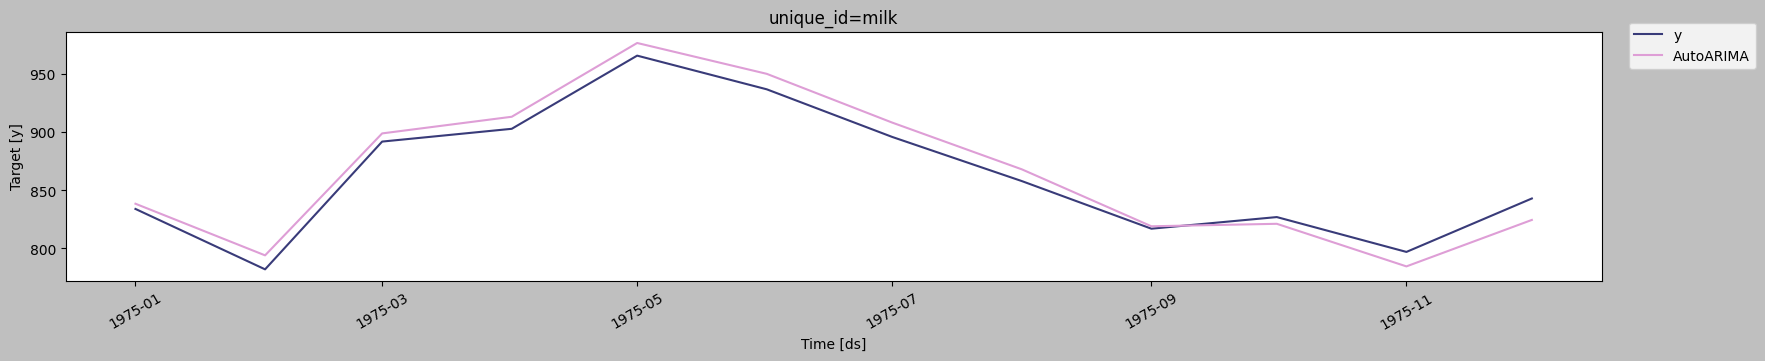

In [192]:
sf.plot(test, forecast)

In [193]:
print(forecast.head())

  unique_id         ds   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0      milk 1975-01-01  838.484088       823.918150       853.050025
1      milk 1975-02-01  794.040733       775.835363       812.246103
2      milk 1975-03-01  899.036196       877.806395       920.265996
3      milk 1975-04-01  913.368435       889.494319       937.242550
4      milk 1975-05-01  976.887264       950.633839      1003.140690


In [194]:
res = Y_test.merge(forecast, how='left', on=['unique_id', 'ds'])
print(res.head())

          ds    y unique_id   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0 1975-01-01  834      milk  838.484088       823.918150       853.050025
1 1975-02-01  782      milk  794.040733       775.835363       812.246103
2 1975-03-01  892      milk  899.036196       877.806395       920.265996
3 1975-04-01  903      milk  913.368435       889.494319       937.242550
4 1975-05-01  966      milk  976.887264       950.633839      1003.140690


In [195]:
mae = abs(res['y']-res['AutoARIMA']).mean()
print('The MAE with exogenous regressors is '+str(round(mae,2)))

The MAE with exogenous regressors is 9.95


In [196]:
# model without exogenous variables (univariate)
forecast_u = sf.forecast(df=train[['unique_id', 'ds', 'y']], h=12)

res_u = Y_test.merge(forecast_u, how='left', on=['unique_id', 'ds'])
mae_u = abs(res_u['y']-res_u['AutoARIMA']).mean()

In [197]:
print('The MAE without exogenous regressors is '+str(round(mae_u,2)))


The MAE without exogenous regressors is 13.56


In [198]:
# Improvement percentage
improvement = ((mae_u - mae) / mae_u) * 100
print(f'Improvement with exogenous variables: {improvement:.1f}%')

Improvement with exogenous variables: 26.6%


## Summary: Choosing the Right Forecasting Method

This notebook demonstrated three powerful approaches to time series forecasting:

### **Facebook Prophet**
- **Best for**: Business forecasting with holidays, events, and trend changes
- **Strengths**: Automatic seasonality detection, robust to missing data, interpretable
- **Use when**: You need production-ready forecasts with minimal tuning

### **Theta Method**
- **Best for**: Simple, interpretable forecasts with clear trend and seasonality
- **Strengths**: Fast computation, component analysis, uncertainty quantification
- **Use when**: You want a statistical method that's easy to understand and explain

### **StatsForecast (Automated)**
- **Best for**: Comparing multiple models, large-scale forecasting, production systems
- **Strengths**: Automatic parameter selection, scalable, comprehensive evaluation
- **Use when**: You need the best possible accuracy with minimal manual intervention

### **Key Takeaways**
1. **Start simple**: Try Theta method first for baseline performance
2. **Add complexity when needed**: Use Prophet for business-specific requirements
3. **Scale up**: Use StatsForecast for production systems and model comparison
4. **Always evaluate**: Use proper cross-validation respecting temporal order
5. **Incorporate domain knowledge**: External variables often improve accuracy significantly

The best method depends on your specific use case, data characteristics, and business requirements. Experiment with multiple approaches and use cross-validation to guide your final choice.